In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

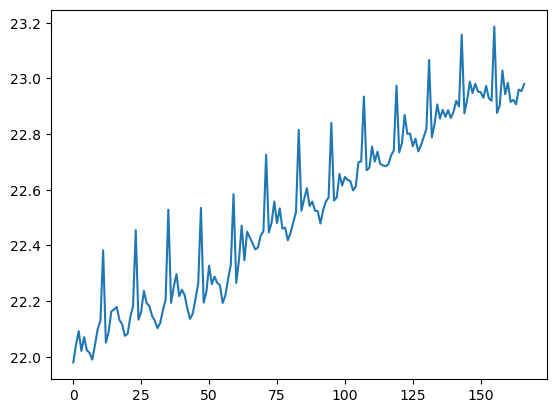

In [4]:
# 対数変換をとる
data = np.loadtxt("../public/seijyo_ishii_monthly_sales_without_header.csv")
series = np.log(data)
plt.plot(series)
plt.show()

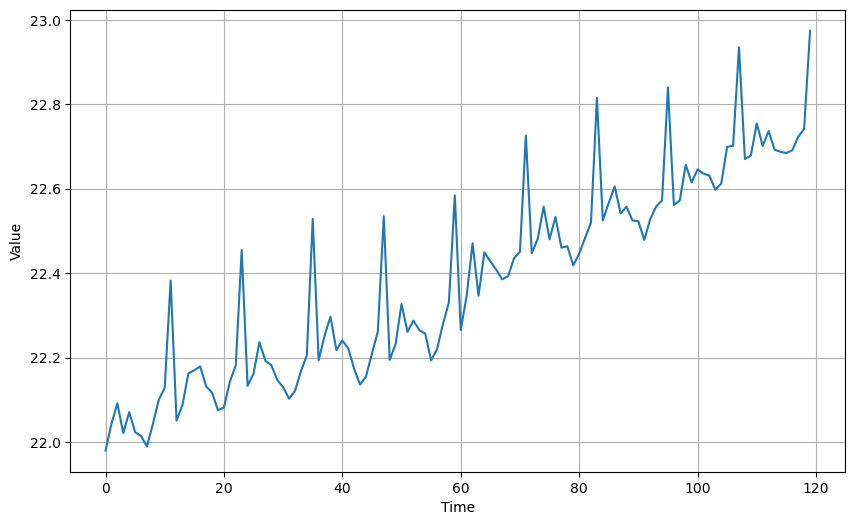

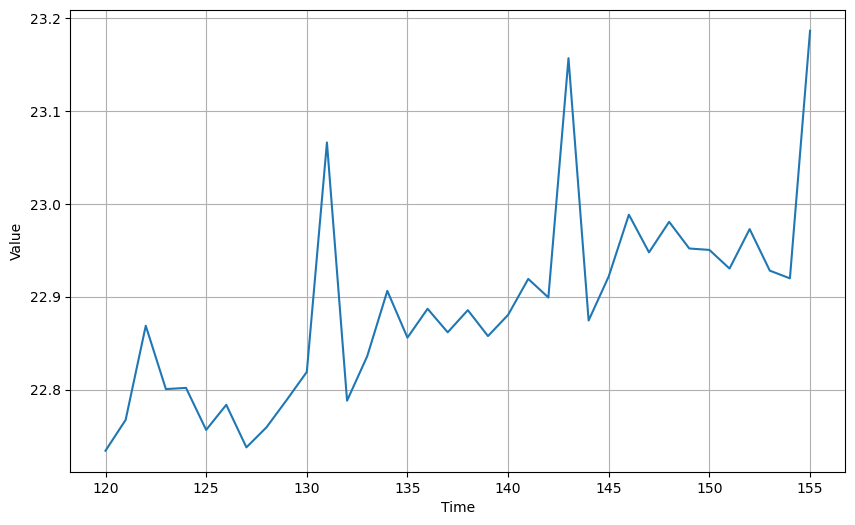

In [5]:
# 前半120時点を学習データ、以降を検証データとして分割

split_time = 120
time = np.arange(156, dtype="float32")    # 2022年12月のデータが取得できれば、168に変更

time_train = time[:split_time]
x_train = series[:split_time]
time_train_pred = time[20:split_time]
time_valid = time[split_time:156]
x_valid = series[split_time:156]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [28]:
%%time
# keras tunerを使って、パラメータを調整する

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units', min_value=10, max_value=30, step=2), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units', min_value=10, max_value=30, step=2)))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units', min_value=10, max_value=30, step=2)))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='hello')

tuner.search_space_summary()

tuner.search(dataset, epochs=1000, verbose=0)

INFO:tensorflow:Reloading Oracle from existing project my_dir/hello/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/hello/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
momentum (Choice)
{'default': 0.9, 'conditions': [], 'values': [0.9, 0.7, 0.5, 0.3], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 36min 47s, sys: 5min 29s, total: 42min 17s
Wall time: 40min 23s


In [29]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Trial summary
Hyperparameters:
units: 30
momentum: 0.3
Score: 0.30029864112536114
Trial summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 0.3034319579601288
Trial summary
Hyperparameters:
units: 24
momentum: 0.3
Score: 0.3068077365557353
Trial summary
Hyperparameters:
units: 12
momentum: 0.7
Score: 0.3095499475797017
Trial summary
Hyperparameters:
units: 26
momentum: 0.7
Score: 0.3204125165939331
Trial summary
Hyperparameters:
units: 20
momentum: 0.9
Score: 0.3297401964664459
Trial summary
Hyperparameters:
units: 20
momentum: 0.5
Score: 0.3332415421803792
Trial summary
Hyperparameters:
units: 18
momentum: 0.5
Score: 0.3342645466327667
Trial summary
Hyperparameters:
units: 14
momentum: 0.7
Score: 0.3402385413646698
Trial summary
Hyperparameters:
units: 20
momentum: 0.7
Score: 0.41155847907066345


In [34]:
%%time
# unitsで統一してしまったため、適切なパラメータがわからない
# keras tunerを使って、パラメータを調整する

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=10, max_value=30, step=2), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units2', min_value=10, max_value=30, step=2)))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units3', min_value=1, max_value=5, step=1)))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='hello')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=0)

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
momentum (Choice)
{'default': 0.9, 'conditions': [], 'values': [0.9, 0.7, 0.5, 0.3], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 12min 44s, sys: 1min 40s, total: 14min 25s
Wall time: 14min 24s


In [35]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 14
units2: 20
units3: 4
momentum: 0.5
Score: 0.36455850799878436
Trial summary
Hyperparameters:
units1: 24
units2: 18
units3: 3
momentum: 0.3
Score: 0.3746763865152995
Trial summary
Hyperparameters:
units1: 10
units2: 30
units3: 3
momentum: 0.5
Score: 0.40430423617362976
Trial summary
Hyperparameters:
units1: 14
units2: 30
units3: 2
momentum: 0.3
Score: 0.4122796456019084
Trial summary
Hyperparameters:
units1: 26
units2: 22
units3: 3
momentum: 0.5
Score: 0.4149121940135956
Trial summary
Hyperparameters:
units1: 28
units2: 18
units3: 3
momentum: 0.9
Score: 0.4158216913541158
Trial summary
Hyperparameters:
units1: 22
units2: 20
units3: 3
momentum: 0.3
Score: 0.42687975366910297
Trial summary
Hyperparameters:
units1: 12
units2: 22
units3: 2
momentum: 0.3
Score: 0.4627292950948079
Trial summary
Hyperparameters:
units1: 24
units2: 16
units3: 2
momentum: 0.5
Score: 0.5339541633923849
Trial s

In [36]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(14, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(20))
model.add(PReLU())
model.add(Dense(4))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000
4/4 [==============================] - 1s 10ms/step - loss: 101.1489
Epoch 2/1000
4/4 [==============================] - 0s 3ms/step - loss: 101.0472
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 100.8664
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 100.6329
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 100.3617
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 100.0627
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 99.7410
Epoch 8/1000
4/4 [==============================] - 0s 3ms/step - loss: 99.4005
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 99.0465
Epoch 10/1000
4/4 [==============================] - 0s 4ms/step - loss: 98.6841
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - loss: 98.3164
Epoch 12/1000
4/4 [==============================] - 0s 4ms/step - loss: 97.9706
Epoch 13/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 65.7554
Epoch 103/1000
4/4 [==============================] - 0s 2ms/step - loss: 65.1162
Epoch 104/1000
4/4 [==============================] - 0s 2ms/step - loss: 64.4641
Epoch 105/1000
4/4 [==============================] - 0s 2ms/step - loss: 63.7997
Epoch 106/1000
4/4 [==============================] - 0s 2ms/step - loss: 63.1219
Epoch 107/1000
4/4 [==============================] - 0s 2ms/step - loss: 62.4304
Epoch 108/1000
4/4 [==============================] - 0s 2ms/step - loss: 61.7253
Epoch 109/1000
4/4 [==============================] - 0s 2ms/step - loss: 61.0072
Epoch 110/1000
4/4 [==============================] - 0s 2ms/step - loss: 60.2773
Epoch 111/1000
4/4 [==============================] - 0s 2ms/step - loss: 59.5362
Epoch 112/1000
4/4 [==============================] - 0s 2ms/step - loss: 58.7846
Epoch 113/1000
4/4 [==============================] - 0s 2ms/step - loss: 58.0182
Epoch 114/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3719
Epoch 203/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3693
Epoch 204/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3676
Epoch 205/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3670
Epoch 206/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3676
Epoch 207/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3711
Epoch 208/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3720
Epoch 209/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3836
Epoch 210/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3733
Epoch 211/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3752
Epoch 212/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3685
Epoch 213/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3649
Epoch 214/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3819
Epoch 304/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3717
Epoch 305/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3791
Epoch 306/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3706
Epoch 307/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3869
Epoch 308/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3734
Epoch 309/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3740
Epoch 310/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3823
Epoch 311/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3681
Epoch 312/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3706
Epoch 313/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.3652
Epoch 314/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3695
Epoch 315/1000
4/4 [======================

4/4 [==============================] - 0s 1ms/step - loss: 0.3718
Epoch 405/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3758
Epoch 406/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3659
Epoch 407/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3814
Epoch 408/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3671
Epoch 409/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3880
Epoch 410/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3762
Epoch 411/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4050
Epoch 412/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3791
Epoch 413/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3644
Epoch 414/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3640
Epoch 415/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3679
Epoch 416/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3743
Epoch 506/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3657
Epoch 507/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3697
Epoch 508/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3734
Epoch 509/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3669
Epoch 510/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3704
Epoch 511/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3699
Epoch 512/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3665
Epoch 513/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3888
Epoch 514/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3764
Epoch 515/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3682
Epoch 516/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3670
Epoch 517/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.3657
Epoch 607/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3658
Epoch 608/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3783
Epoch 609/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3662
Epoch 610/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3737
Epoch 611/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3804
Epoch 612/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3699
Epoch 613/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3736
Epoch 614/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3704
Epoch 615/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3653
Epoch 616/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.3709
Epoch 617/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3645
Epoch 618/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3801
Epoch 708/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3670
Epoch 709/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3748
Epoch 710/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3629
Epoch 711/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3856
Epoch 712/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3824
Epoch 713/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3737
Epoch 714/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3762
Epoch 715/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3707
Epoch 716/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3664
Epoch 717/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3726
Epoch 718/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3655
Epoch 719/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3746
Epoch 809/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3729
Epoch 810/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3706
Epoch 811/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3805
Epoch 812/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.3667
Epoch 813/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.3750
Epoch 814/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3650
Epoch 815/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3756
Epoch 816/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3667
Epoch 817/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3756
Epoch 818/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3787
Epoch 819/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3638
Epoch 820/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3775
Epoch 910/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3703
Epoch 911/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3751
Epoch 912/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3696
Epoch 913/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3673
Epoch 914/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3651
Epoch 915/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3617
Epoch 916/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3653
Epoch 917/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3646
Epoch 918/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3694
Epoch 919/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3637
Epoch 920/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3654
Epoch 921/1000
4/4 [=======================

1/1 [==============================] - 0s 16ms/step


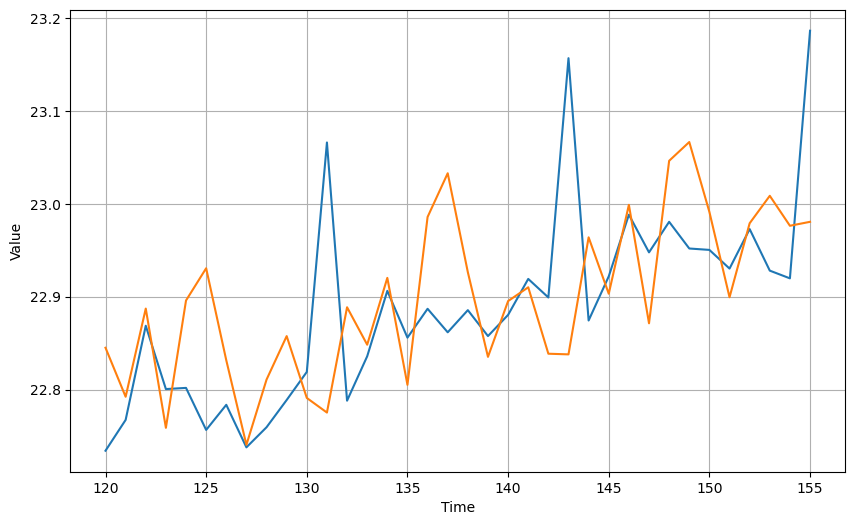

In [40]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

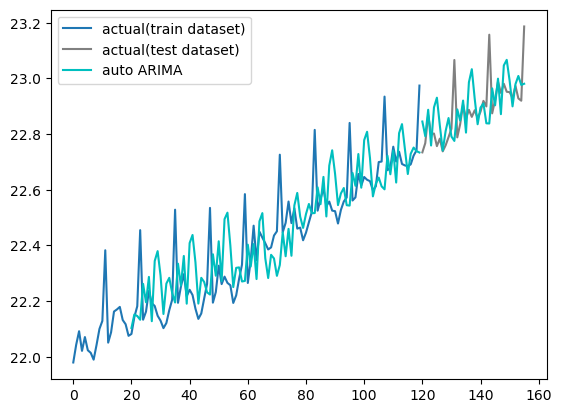

In [41]:
# グラフ化

fig, ax = plt.subplots()
ax.plot(time_train, x_train, label="actual(train dataset)")
ax.plot(time_valid, x_valid, label="actual(test dataset)", color="gray")
ax.plot(time_train_pred, train_pred, color="c")
ax.plot(time_valid, test_pred, label="auto ARIMA", color="c") 
# ax.fill_between(
#     df_log_test.index,
#     test_pred_ci[:, 0],
#     test_pred_ci[:, 1],
#     color='c',
#     alpha=.2)
ax.legend()

In [42]:
# 時短のためにエポック100でパラメータチューニングをしたが、やはり少ないか

In [43]:
%%time
# unitsで統一してしまったため、適切なパラメータがわからない
# keras tunerを使って、パラメータを調整する

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=10, max_value=30, step=2), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units2', min_value=10, max_value=30, step=2)))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units3', min_value=1, max_value=5, step=1)))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-6))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='hello')

tuner.search_space_summary()

tuner.search(dataset, epochs=5000, verbose=0)

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
momentum (Choice)
{'default': 0.9, 'conditions': [], 'values': [0.9, 0.7, 0.5, 0.3], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 6h 23min 18s, sys: 53min 15s, total: 7h 16min 33s
Wall time: 5h 51min 23s


In [45]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 22
units2: 30
units3: 1
momentum: 0.5
Score: 0.26777254541714984
Trial summary
Hyperparameters:
units1: 26
units2: 16
units3: 2
momentum: 0.3
Score: 0.3066685100396474
Trial summary
Hyperparameters:
units1: 28
units2: 24
units3: 3
momentum: 0.3
Score: 0.3072974880536397
Trial summary
Hyperparameters:
units1: 28
units2: 20
units3: 3
momentum: 0.5
Score: 0.31566089391708374
Trial summary
Hyperparameters:
units1: 26
units2: 24
units3: 3
momentum: 0.9
Score: 0.3184248010317485
Trial summary
Hyperparameters:
units1: 24
units2: 22
units3: 1
momentum: 0.7
Score: 0.31966591874758404
Trial summary
Hyperparameters:
units1: 28
units2: 16
units3: 5
momentum: 0.5
Score: 0.3201005260149638
Trial summary
Hyperparameters:
units1: 26
units2: 16
units3: 4
momentum: 0.9
Score: 0.32030515869458515
Trial summary
Hyperparameters:
units1: 20
units2: 20
units3: 2
momentum: 0.7
Score: 0.32119040687878925
Trial

In [51]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(22, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(30))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=5000,verbose=1)

Epoch 1/5000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 34ms/step - loss: 133.5308
Epoch 2/5000
4/4 [==============================] - 0s 3ms/step - loss: 131.9647
Epoch 3/5000
4/4 [==============================] - 0s 3ms/step - loss: 130.1788
Epoch 4/5000
4/4 [==============================] - 0s 4ms/step - loss: 128.3833
Epoch 5/5000
4/4 [==============================] - 0s 4ms/step - loss: 126.5909
Epoch 6/5000
4/4 [==============================] - 0s 4ms/step - loss: 124.8027
Epoch 7/5000
4/4 [==============================] - 0s 13ms/step - loss: 123.0194
Epoch 8/5000
4/4 [==============================] - 0s 4ms/step - loss: 121.2389
Epoch 9/5000
4/4 [==============================] - 0s 4ms/step - loss: 119.4608
Epoch 10/5000
4/4 [==============================] - 0s 3ms/step - loss: 117.6876
Epoch 11/5000
4/4 [==============================] - 0s 3ms/step - loss: 115.9171
Epoch 12/5000
4/4 [==============================] - 0s 3ms/step - loss: 114.1475
Epoch 13/5000
4/4 [=================

4/4 [==============================] - 0s 7ms/step - loss: 0.3436
Epoch 103/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3287
Epoch 104/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3500
Epoch 105/5000
4/4 [==============================] - 0s 10ms/step - loss: 0.3274
Epoch 106/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3299
Epoch 107/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3291
Epoch 108/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3327
Epoch 109/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 110/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3859
Epoch 111/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3268
Epoch 112/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3293
Epoch 113/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3273
Epoch 114/5000
4/4 [======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 204/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3349
Epoch 205/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3375
Epoch 206/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3295
Epoch 207/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3305
Epoch 208/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3330
Epoch 209/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 210/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3317
Epoch 211/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 212/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3444
Epoch 213/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3352
Epoch 214/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3458
Epoch 215/5000
4/4 [=======================

4/4 [==============================] - 0s 7ms/step - loss: 0.3317
Epoch 305/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3658
Epoch 306/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3468
Epoch 307/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3363
Epoch 308/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3474
Epoch 309/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 310/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3297
Epoch 311/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3337
Epoch 312/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3420
Epoch 313/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 314/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3283
Epoch 315/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3262
Epoch 316/5000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3560
Epoch 406/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3286
Epoch 407/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3311
Epoch 408/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3848
Epoch 409/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 410/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3370
Epoch 411/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3441
Epoch 412/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3370
Epoch 413/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3558
Epoch 414/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3448
Epoch 415/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3456
Epoch 416/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3294
Epoch 417/5000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.3489
Epoch 507/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3266
Epoch 508/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3285
Epoch 509/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3419
Epoch 510/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3479
Epoch 511/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3311
Epoch 512/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3288
Epoch 513/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3287
Epoch 514/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3274
Epoch 515/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.4242
Epoch 516/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3254
Epoch 517/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.4016
Epoch 518/5000
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 0.3281
Epoch 608/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3466
Epoch 609/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3309
Epoch 610/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3882
Epoch 611/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3762
Epoch 612/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3507
Epoch 613/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3318
Epoch 614/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3390
Epoch 615/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3281
Epoch 616/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3584
Epoch 617/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3483
Epoch 618/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3430
Epoch 619/5000
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 0.3464
Epoch 709/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3377
Epoch 710/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3335
Epoch 711/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3331
Epoch 712/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3259
Epoch 713/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 714/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3270
Epoch 715/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3508
Epoch 716/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3273
Epoch 717/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3305
Epoch 718/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3299
Epoch 719/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3410
Epoch 720/5000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3510
Epoch 810/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3377
Epoch 811/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3445
Epoch 812/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3348
Epoch 813/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3308
Epoch 814/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3315
Epoch 815/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3346
Epoch 816/5000
4/4 [==============================] - 0s 33ms/step - loss: 0.3267
Epoch 817/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3568
Epoch 818/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3386
Epoch 819/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.4122
Epoch 820/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3368
Epoch 821/5000
4/4 [======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3681
Epoch 911/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3287
Epoch 912/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3292
Epoch 913/5000
4/4 [==============================] - 0s 7ms/step - loss: 0.3252
Epoch 914/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3331
Epoch 915/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3253
Epoch 916/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3400
Epoch 917/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3347
Epoch 918/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3353
Epoch 919/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3333
Epoch 920/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3591
Epoch 921/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3290
Epoch 922/5000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3341
Epoch 1012/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3504
Epoch 1013/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3599
Epoch 1014/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3554
Epoch 1015/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3416
Epoch 1016/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3338
Epoch 1017/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3369
Epoch 1018/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3302
Epoch 1019/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3267
Epoch 1020/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3429
Epoch 1021/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3280
Epoch 1022/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3433
Epoch 1023/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3304
Epoch 1112/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3433
Epoch 1113/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3607
Epoch 1114/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3579
Epoch 1115/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3248
Epoch 1116/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3326
Epoch 1117/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3464
Epoch 1118/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3282
Epoch 1119/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3474
Epoch 1120/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3423
Epoch 1121/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3360
Epoch 1122/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3391
Epoch 1123/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3446
Epoch 1212/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3290
Epoch 1213/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3619
Epoch 1214/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3593
Epoch 1215/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3424
Epoch 1216/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3259
Epoch 1217/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3277
Epoch 1218/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.4001
Epoch 1219/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3472
Epoch 1220/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3656
Epoch 1221/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3527
Epoch 1222/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3414
Epoch 1223/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3320
Epoch 1312/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3440
Epoch 1313/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3607
Epoch 1314/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3396
Epoch 1315/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3269
Epoch 1316/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3379
Epoch 1317/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3241
Epoch 1318/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3261
Epoch 1319/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3713
Epoch 1320/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3280
Epoch 1321/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3470
Epoch 1322/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 1323/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 1412/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3340
Epoch 1413/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3352
Epoch 1414/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3304
Epoch 1415/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3281
Epoch 1416/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3243
Epoch 1417/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3502
Epoch 1418/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3409
Epoch 1419/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3402
Epoch 1420/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3349
Epoch 1421/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3318
Epoch 1422/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3311
Epoch 1423/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3616
Epoch 1512/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3354
Epoch 1513/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3293
Epoch 1514/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3364
Epoch 1515/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3679
Epoch 1516/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3783
Epoch 1517/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3280
Epoch 1518/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 1519/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3271
Epoch 1520/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3309
Epoch 1521/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3480
Epoch 1522/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3758
Epoch 1523/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3343
Epoch 1612/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3324
Epoch 1613/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3336
Epoch 1614/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3463
Epoch 1615/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3362
Epoch 1616/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.4298
Epoch 1617/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3773
Epoch 1618/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3330
Epoch 1619/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3316
Epoch 1620/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3441
Epoch 1621/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3342
Epoch 1622/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3281
Epoch 1623/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3502
Epoch 1712/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3306
Epoch 1713/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3478
Epoch 1714/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3621
Epoch 1715/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3522
Epoch 1716/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3683
Epoch 1717/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3266
Epoch 1718/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3315
Epoch 1719/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3383
Epoch 1720/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3311
Epoch 1721/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3586
Epoch 1722/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3358
Epoch 1723/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3429
Epoch 1812/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3411
Epoch 1813/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3343
Epoch 1814/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 1815/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3249
Epoch 1816/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3689
Epoch 1817/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3410
Epoch 1818/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3633
Epoch 1819/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3949
Epoch 1820/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3436
Epoch 1821/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3253
Epoch 1822/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3263
Epoch 1823/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 0.3491
Epoch 1912/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3250
Epoch 1913/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3278
Epoch 1914/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 1915/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3366
Epoch 1916/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3284
Epoch 1917/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3576
Epoch 1918/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3432
Epoch 1919/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3255
Epoch 1920/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 1921/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3813
Epoch 1922/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3437
Epoch 1923/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3441
Epoch 2012/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3687
Epoch 2013/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3865
Epoch 2014/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3258
Epoch 2015/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3340
Epoch 2016/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3273
Epoch 2017/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3282
Epoch 2018/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3607
Epoch 2019/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3503
Epoch 2020/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3384
Epoch 2021/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 2022/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3414
Epoch 2023/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3403
Epoch 2112/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3288
Epoch 2113/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3637
Epoch 2114/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3601
Epoch 2115/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3385
Epoch 2116/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3465
Epoch 2117/5000
4/4 [==============================] - 0s 10ms/step - loss: 0.3243
Epoch 2118/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3426
Epoch 2119/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3272
Epoch 2120/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3270
Epoch 2121/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3345
Epoch 2122/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3777
Epoch 2123/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 0.3958
Epoch 2212/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3316
Epoch 2213/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3429
Epoch 2214/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3299
Epoch 2215/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3300
Epoch 2216/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3308
Epoch 2217/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3322
Epoch 2218/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3256
Epoch 2219/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3471
Epoch 2220/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3264
Epoch 2221/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3436
Epoch 2222/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3542
Epoch 2223/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3391
Epoch 2312/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3310
Epoch 2313/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3550
Epoch 2314/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3692
Epoch 2315/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3776
Epoch 2316/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3270
Epoch 2317/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3548
Epoch 2318/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3547
Epoch 2319/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3916
Epoch 2320/5000
4/4 [==============================] - 0s 8ms/step - loss: 0.3324
Epoch 2321/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3241
Epoch 2322/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 2323/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3509
Epoch 2412/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3428
Epoch 2413/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3382
Epoch 2414/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3263
Epoch 2415/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3326
Epoch 2416/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3772
Epoch 2417/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3291
Epoch 2418/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3289
Epoch 2419/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3271
Epoch 2420/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3275
Epoch 2421/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3321
Epoch 2422/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3301
Epoch 2423/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 0.3478
Epoch 2512/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3263
Epoch 2513/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3373
Epoch 2514/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3321
Epoch 2515/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3298
Epoch 2516/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3258
Epoch 2517/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3442
Epoch 2518/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3299
Epoch 2519/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3257
Epoch 2520/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3374
Epoch 2521/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3298
Epoch 2522/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3994
Epoch 2523/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3390
Epoch 2612/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3292
Epoch 2613/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3336
Epoch 2614/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3257
Epoch 2615/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 2616/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3235
Epoch 2617/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3247
Epoch 2618/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3375
Epoch 2619/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3294
Epoch 2620/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3271
Epoch 2621/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3364
Epoch 2622/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3438
Epoch 2623/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3469
Epoch 2712/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3278
Epoch 2713/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3275
Epoch 2714/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.3305
Epoch 2715/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3299
Epoch 2716/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3246
Epoch 2717/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3340
Epoch 2718/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3774
Epoch 2719/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3282
Epoch 2720/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 2721/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3346
Epoch 2722/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 2723/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3303
Epoch 2812/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3246
Epoch 2813/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3266
Epoch 2814/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3543
Epoch 2815/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3248
Epoch 2816/5000
4/4 [==============================] - 0s 7ms/step - loss: 0.3301
Epoch 2817/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3312
Epoch 2818/5000
4/4 [==============================] - 0s 8ms/step - loss: 0.3271
Epoch 2819/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3237
Epoch 2820/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3609
Epoch 2821/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3269
Epoch 2822/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3605
Epoch 2823/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3535
Epoch 2912/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3561
Epoch 2913/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 2914/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3540
Epoch 2915/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3588
Epoch 2916/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3925
Epoch 2917/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3242
Epoch 2918/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3287
Epoch 2919/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3521
Epoch 2920/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3968
Epoch 2921/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3574
Epoch 2922/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3855
Epoch 2923/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3336
Epoch 3012/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3238
Epoch 3013/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3381
Epoch 3014/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3376
Epoch 3015/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3514
Epoch 3016/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3270
Epoch 3017/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.3367
Epoch 3018/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3790
Epoch 3019/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3367
Epoch 3020/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3632
Epoch 3021/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3335
Epoch 3022/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3245
Epoch 3023/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3284
Epoch 3112/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3362
Epoch 3113/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3308
Epoch 3114/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3406
Epoch 3115/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3441
Epoch 3116/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3414
Epoch 3117/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3291
Epoch 3118/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3533
Epoch 3119/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3396
Epoch 3120/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 3121/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3276
Epoch 3122/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3405
Epoch 3123/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3318
Epoch 3212/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3847
Epoch 3213/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3538
Epoch 3214/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3276
Epoch 3215/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3269
Epoch 3216/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3573
Epoch 3217/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3383
Epoch 3218/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3886
Epoch 3219/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3816
Epoch 3220/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3434
Epoch 3221/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3266
Epoch 3222/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3310
Epoch 3223/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3247
Epoch 3312/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3424
Epoch 3313/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3229
Epoch 3314/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3258
Epoch 3315/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3339
Epoch 3316/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3497
Epoch 3317/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3297
Epoch 3318/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3459
Epoch 3319/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3276
Epoch 3320/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3246
Epoch 3321/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 3322/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3379
Epoch 3323/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3649
Epoch 3412/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3306
Epoch 3413/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3288
Epoch 3414/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3374
Epoch 3415/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3280
Epoch 3416/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3588
Epoch 3417/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3300
Epoch 3418/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3266
Epoch 3419/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3264
Epoch 3420/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3293
Epoch 3421/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3580
Epoch 3422/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3254
Epoch 3423/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3331
Epoch 3512/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3437
Epoch 3513/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 3514/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3481
Epoch 3515/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3429
Epoch 3516/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3256
Epoch 3517/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3357
Epoch 3518/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3492
Epoch 3519/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3379
Epoch 3520/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3370
Epoch 3521/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3295
Epoch 3522/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3443
Epoch 3523/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3292
Epoch 3612/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 3613/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3550
Epoch 3614/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3313
Epoch 3615/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 3616/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3800
Epoch 3617/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3770
Epoch 3618/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3558
Epoch 3619/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3308
Epoch 3620/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3403
Epoch 3621/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 3622/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3326
Epoch 3623/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3295
Epoch 3712/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3346
Epoch 3713/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3285
Epoch 3714/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3389
Epoch 3715/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3237
Epoch 3716/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3351
Epoch 3717/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3519
Epoch 3718/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3298
Epoch 3719/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3419
Epoch 3720/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3774
Epoch 3721/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3307
Epoch 3722/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3328
Epoch 3723/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3256
Epoch 3812/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3263
Epoch 3813/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3271
Epoch 3814/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3273
Epoch 3815/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3277
Epoch 3816/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3311
Epoch 3817/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3285
Epoch 3818/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3750
Epoch 3819/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3582
Epoch 3820/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3229
Epoch 3821/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3483
Epoch 3822/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3743
Epoch 3823/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3247
Epoch 3912/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3309
Epoch 3913/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3384
Epoch 3914/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3228
Epoch 3915/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3359
Epoch 3916/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3860
Epoch 3917/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3436
Epoch 3918/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3279
Epoch 3919/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3334
Epoch 3920/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3804
Epoch 3921/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3311
Epoch 3922/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3306
Epoch 3923/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3323
Epoch 4012/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3499
Epoch 4013/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3494
Epoch 4014/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3401
Epoch 4015/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3304
Epoch 4016/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3275
Epoch 4017/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3288
Epoch 4018/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3448
Epoch 4019/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3300
Epoch 4020/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3757
Epoch 4021/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3369
Epoch 4022/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3554
Epoch 4023/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3350
Epoch 4112/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3479
Epoch 4113/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3261
Epoch 4114/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3274
Epoch 4115/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3402
Epoch 4116/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3254
Epoch 4117/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3302
Epoch 4118/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3357
Epoch 4119/5000
4/4 [==============================] - 0s 7ms/step - loss: 0.3440
Epoch 4120/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3287
Epoch 4121/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3310
Epoch 4122/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3267
Epoch 4123/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3280
Epoch 4212/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3319
Epoch 4213/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 4214/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3247
Epoch 4215/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3316
Epoch 4216/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3349
Epoch 4217/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3414
Epoch 4218/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3296
Epoch 4219/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 4220/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3275
Epoch 4221/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3396
Epoch 4222/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3311
Epoch 4223/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3349
Epoch 4312/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3239
Epoch 4313/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3305
Epoch 4314/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3416
Epoch 4315/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3822
Epoch 4316/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3231
Epoch 4317/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3594
Epoch 4318/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3443
Epoch 4319/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3424
Epoch 4320/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3429
Epoch 4321/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3289
Epoch 4322/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3363
Epoch 4323/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3380
Epoch 4412/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3341
Epoch 4413/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3313
Epoch 4414/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3259
Epoch 4415/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3280
Epoch 4416/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3227
Epoch 4417/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3442
Epoch 4418/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3257
Epoch 4419/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3333
Epoch 4420/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3259
Epoch 4421/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3324
Epoch 4422/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3390
Epoch 4423/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 0.3336
Epoch 4512/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3291
Epoch 4513/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3301
Epoch 4514/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3357
Epoch 4515/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3347
Epoch 4516/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3314
Epoch 4517/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3257
Epoch 4518/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3374
Epoch 4519/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3229
Epoch 4520/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3396
Epoch 4521/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3299
Epoch 4522/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3258
Epoch 4523/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 0.3750
Epoch 4612/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3277
Epoch 4613/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3326
Epoch 4614/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3248
Epoch 4615/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3278
Epoch 4616/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3403
Epoch 4617/5000
4/4 [==============================] - 0s 5ms/step - loss: 0.3218
Epoch 4618/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3240
Epoch 4619/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 4620/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3217
Epoch 4621/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3303
Epoch 4622/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3379
Epoch 4623/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3549
Epoch 4712/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3300
Epoch 4713/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3289
Epoch 4714/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 4715/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3347
Epoch 4716/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3218
Epoch 4717/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3220
Epoch 4718/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3353
Epoch 4719/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3228
Epoch 4720/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3237
Epoch 4721/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3354
Epoch 4722/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3328
Epoch 4723/5000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3314
Epoch 4812/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3240
Epoch 4813/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3233
Epoch 4814/5000
4/4 [==============================] - 0s 6ms/step - loss: 0.3446
Epoch 4815/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3849
Epoch 4816/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3316
Epoch 4817/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3586
Epoch 4818/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3284
Epoch 4819/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3253
Epoch 4820/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3258
Epoch 4821/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3776
Epoch 4822/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3458
Epoch 4823/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3432
Epoch 4912/5000
4/4 [==============================] - 0s 1ms/step - loss: 0.3249
Epoch 4913/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3483
Epoch 4914/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3383
Epoch 4915/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3318
Epoch 4916/5000
4/4 [==============================] - 0s 3ms/step - loss: 0.3380
Epoch 4917/5000
4/4 [==============================] - 0s 4ms/step - loss: 0.3637
Epoch 4918/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3311
Epoch 4919/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 4920/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3269
Epoch 4921/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3292
Epoch 4922/5000
4/4 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 4923/5000
4/4 [===========

1/1 [==============================] - 0s 16ms/step


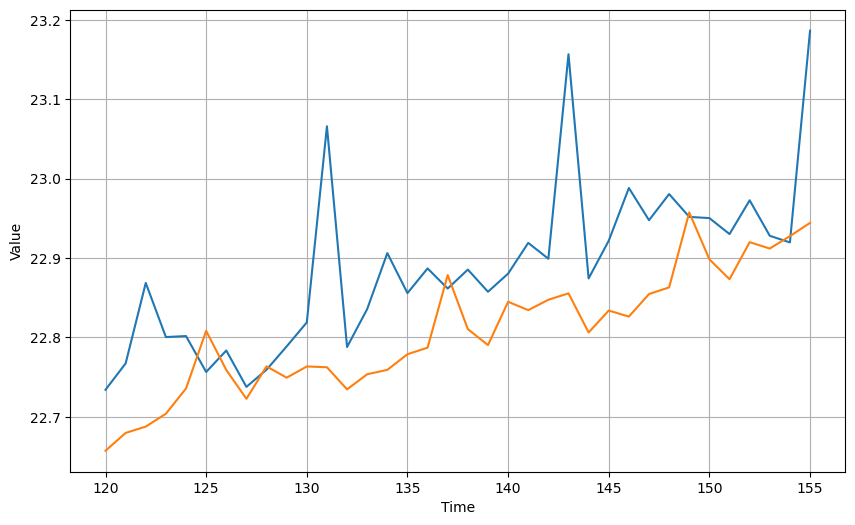

In [52]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

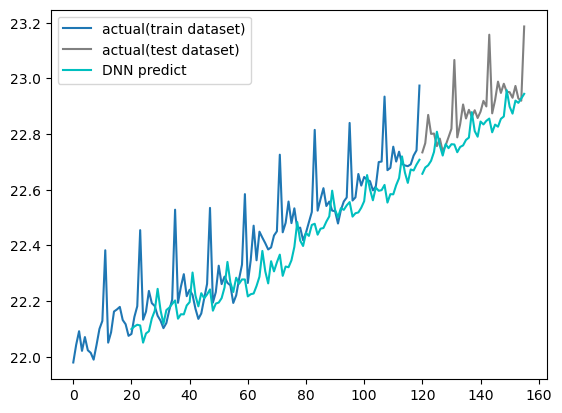

In [53]:
# グラフ化

fig, ax = plt.subplots()
ax.plot(time_train, x_train, label="actual(train dataset)")
ax.plot(time_valid, x_valid, label="actual(test dataset)", color="gray")
ax.plot(time_train_pred, train_pred, color="c")
ax.plot(time_valid, test_pred, label="DNN predict", color="c") 
# ax.fill_between(
#     df_log_test.index,
#     test_pred_ci[:, 0],
#     test_pred_ci[:, 1],
#     color='c',
#     alpha=.2)
ax.legend()

In [54]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.0036984021282618013


In [11]:
# エポック数5000でkeras tunerでチューニングするのは微妙だった

In [15]:
# エポック数とバッチサイズをチューニングするドキュメントを見つけた
# https://github.com/keras-team/keras-tuner/issues/122

In [19]:
# あまり役に立たなさそうだった

In [20]:
# エポック数をチューニングできなかったため、自力でそこそこのエポック数を見つける必要がある

In [21]:
%%time
# まずはPReLUでエポック数を確認する
# エポック数：100
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 45ms/step - loss: 83.2655
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 81.7986
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 80.4346
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 79.4238
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 78.4933
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 77.6915
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 77.0182
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 76.3807
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 75.7516
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 75.1206
Epoch 11/100
4/4 [==============================] - 0s 3ms/step - loss: 74.4885
Epoch 12/100
4/4 [==============================] - 0s 2ms/step - loss: 73.8582
Epoch 13/100
4/4 [==============================

1/1 [==============================] - 0s 16ms/step


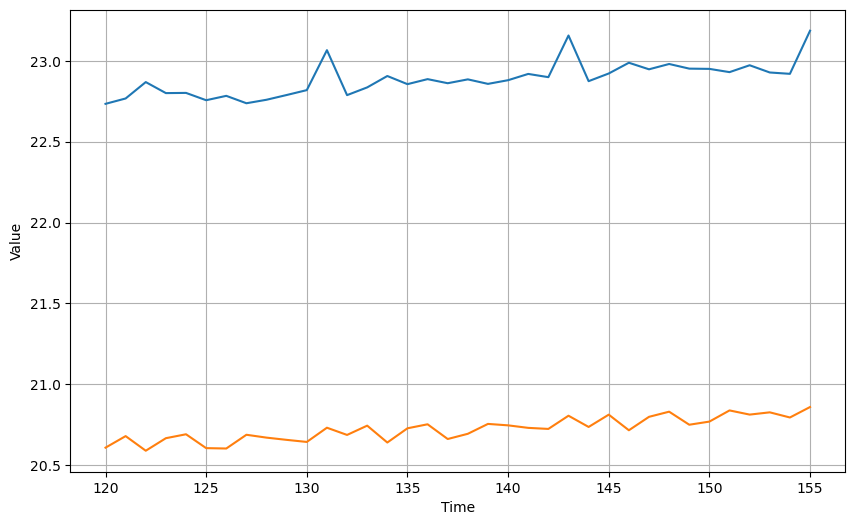

In [22]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

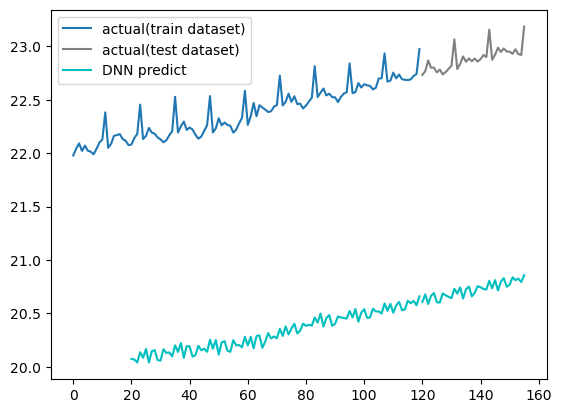

In [23]:
# グラフ化

fig, ax = plt.subplots()
ax.plot(time_train, x_train, label="actual(train dataset)")
ax.plot(time_valid, x_valid, label="actual(test dataset)", color="gray")
ax.plot(time_train_pred, train_pred, color="c")
ax.plot(time_valid, test_pred, label="DNN predict", color="c") 
# ax.fill_between(
#     df_log_test.index,
#     test_pred_ci[:, 0],
#     test_pred_ci[:, 1],
#     color='c',
#     alpha=.2)
ax.legend()

In [24]:
%%time
# エポック数：500
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 0s 7ms/step - loss: 116.9140
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 116.5512
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 116.1382
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 115.7234
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 115.3098
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 114.8976
Epoch 7/500
4/4 [==============================] - 0s 15ms/step - loss: 114.4869
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 114.0775
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 113.6695
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 113.2629
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 112.8576
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 112.4537
Epoch 13/500
4/4 [==================

4/4 [==============================] - 0s 2ms/step - loss: 80.7934
Epoch 103/500
4/4 [==============================] - 0s 2ms/step - loss: 80.5747
Epoch 104/500
4/4 [==============================] - 0s 2ms/step - loss: 80.3564
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 80.1362
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 79.9150
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 79.6935
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 79.4703
Epoch 109/500
4/4 [==============================] - 0s 6ms/step - loss: 79.2453
Epoch 110/500
4/4 [==============================] - 0s 14ms/step - loss: 79.0198
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 78.7931
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 78.5652
Epoch 113/500
4/4 [==============================] - 0s 5ms/step - loss: 78.3364
Epoch 114/500
4/4 [======================

4/4 [==============================] - 0s 3ms/step - loss: 50.5521
Epoch 204/500
4/4 [==============================] - 0s 3ms/step - loss: 50.1337
Epoch 205/500
4/4 [==============================] - 0s 2ms/step - loss: 49.7124
Epoch 206/500
4/4 [==============================] - 0s 2ms/step - loss: 49.2875
Epoch 207/500
4/4 [==============================] - 0s 2ms/step - loss: 48.8591
Epoch 208/500
4/4 [==============================] - 0s 2ms/step - loss: 48.4277
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 47.9934
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 47.5550
Epoch 211/500
4/4 [==============================] - 0s 2ms/step - loss: 47.1140
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 46.6684
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 46.2199
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 45.7680
Epoch 215/500
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.2725
Epoch 305/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2807
Epoch 306/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2708
Epoch 307/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2715
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2699
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2707
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2891
Epoch 311/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2688
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2785
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2736
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2864
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2820
Epoch 316/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.2683
Epoch 407/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2699
Epoch 408/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2795
Epoch 409/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2811
Epoch 410/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2721
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2717
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2853
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2708
Epoch 414/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2691
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2694
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2888
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2953
Epoch 418/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 18ms/step


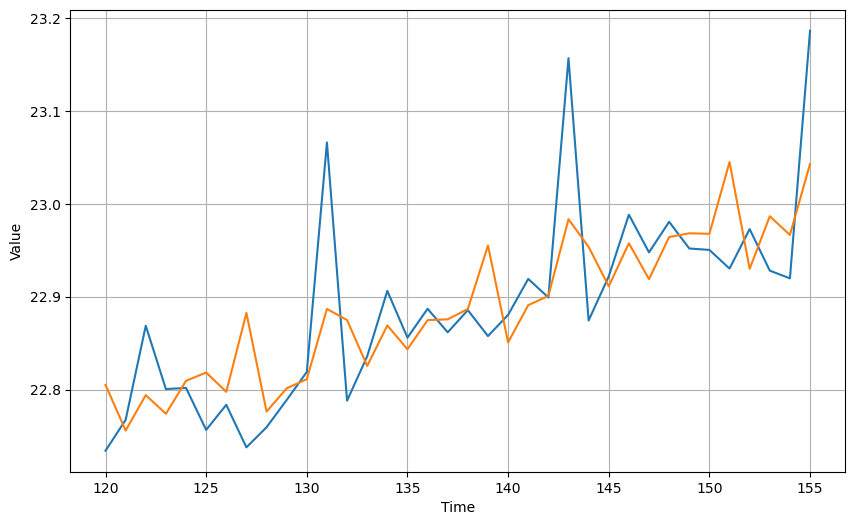

In [25]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

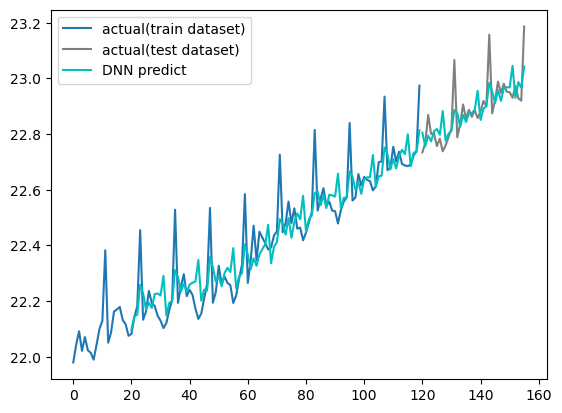

In [26]:
# グラフ化

fig, ax = plt.subplots()
ax.plot(time_train, x_train, label="actual(train dataset)")
ax.plot(time_valid, x_valid, label="actual(test dataset)", color="gray")
ax.plot(time_train_pred, train_pred, color="c")
ax.plot(time_valid, test_pred, label="DNN predict", color="c") 
# ax.fill_between(
#     df_log_test.index,
#     test_pred_ci[:, 0],
#     test_pred_ci[:, 1],
#     color='c',
#     alpha=.2)
ax.legend()

In [27]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.002106960658467709


In [28]:
%%time
# エポック数：1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 0s 9ms/step - loss: 16.8964
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 15.6983
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 14.3589
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 13.0851
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 11.8195
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 10.5485
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 9.2695
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 7.9824
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 6.6872
Epoch 10/1000
4/4 [==============================] - 0s 3ms/step - loss: 5.3836
Epoch 11/1000
4/4 [==============================] - 0s 3ms/step - loss: 4.0720
Epoch 12/1000
4/4 [==============================] - 0s 3ms/step - loss: 2.7519
Epoch 13/1000
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 2ms/step - loss: 0.2913
Epoch 104/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2916
Epoch 105/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2865
Epoch 106/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2859
Epoch 107/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2851
Epoch 108/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2878
Epoch 109/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2881
Epoch 110/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2870
Epoch 111/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2949
Epoch 112/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2860
Epoch 113/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2866
Epoch 114/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2994
Epoch 115/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.2955
Epoch 205/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2879
Epoch 206/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2985
Epoch 207/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3119
Epoch 208/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2889
Epoch 209/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.2937
Epoch 210/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.2842
Epoch 211/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2853
Epoch 212/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.2881
Epoch 213/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2911
Epoch 214/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3008
Epoch 215/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3143
Epoch 216/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3148
Epoch 306/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2879
Epoch 307/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2873
Epoch 308/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3091
Epoch 309/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2864
Epoch 310/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2862
Epoch 311/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2973
Epoch 312/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2869
Epoch 313/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.2929
Epoch 314/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.2919
Epoch 315/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 316/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 317/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.2835
Epoch 407/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2907
Epoch 408/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2863
Epoch 409/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2933
Epoch 410/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2948
Epoch 411/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2875
Epoch 412/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2835
Epoch 413/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2864
Epoch 414/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2852
Epoch 415/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3042
Epoch 416/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2853
Epoch 417/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2900
Epoch 418/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.2965
Epoch 508/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3188
Epoch 509/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2848
Epoch 510/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.2943
Epoch 511/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3167
Epoch 512/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3193
Epoch 513/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 514/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3445
Epoch 515/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3182
Epoch 516/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3062
Epoch 517/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2921
Epoch 518/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2853
Epoch 519/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.2887
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2852
Epoch 610/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.3215
Epoch 611/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2847
Epoch 612/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2940
Epoch 613/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2907
Epoch 614/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2835
Epoch 615/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2908
Epoch 616/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2864
Epoch 617/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2836
Epoch 618/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2860
Epoch 619/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3110
Epoch 620/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.2909
Epoch 710/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2874
Epoch 711/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.3215
Epoch 712/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2937
Epoch 713/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2910
Epoch 714/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2843
Epoch 715/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2848
Epoch 716/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2882
Epoch 717/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2841
Epoch 718/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2874
Epoch 719/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2912
Epoch 720/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2904
Epoch 721/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.2905
Epoch 811/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2842
Epoch 812/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2847
Epoch 813/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 814/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2845
Epoch 815/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2907
Epoch 816/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2863
Epoch 817/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2901
Epoch 818/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2854
Epoch 819/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2874
Epoch 820/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2913
Epoch 821/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2908
Epoch 822/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.2838
Epoch 912/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2838
Epoch 913/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2846
Epoch 914/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.2856
Epoch 915/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2902
Epoch 916/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2855
Epoch 917/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2856
Epoch 918/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2900
Epoch 919/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 920/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.2919
Epoch 921/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2847
Epoch 922/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.2988
Epoch 923/1000
4/4 [=======================

1/1 [==============================] - 0s 14ms/step


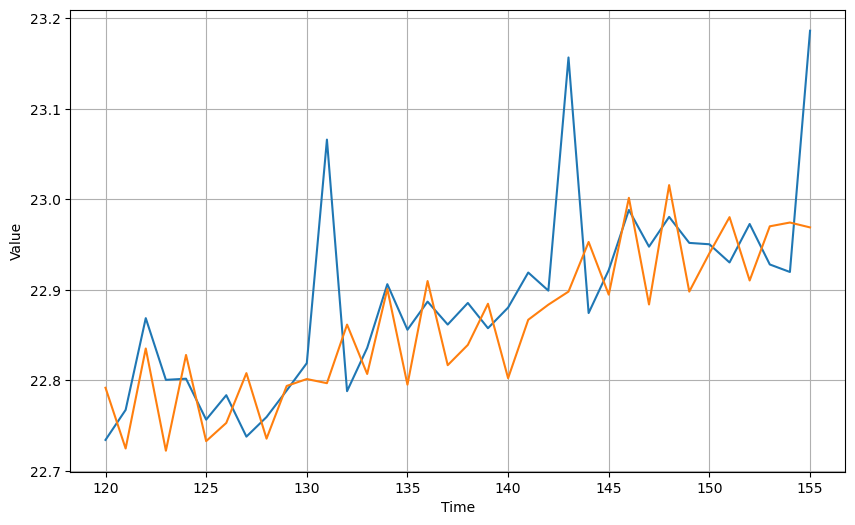

In [29]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [30]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.0025427217804988578


In [31]:
%%time
# エポック数：2000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=2000,verbose=1)

Epoch 1/2000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 9ms/step - loss: 58.7809
Epoch 2/2000
4/4 [==============================] - 0s 7ms/step - loss: 56.5204
Epoch 3/2000
4/4 [==============================] - 0s 6ms/step - loss: 53.9319
Epoch 4/2000
4/4 [==============================] - 0s 3ms/step - loss: 51.3167
Epoch 5/2000
4/4 [==============================] - 0s 3ms/step - loss: 48.6935
Epoch 6/2000
4/4 [==============================] - 0s 4ms/step - loss: 46.0629
Epoch 7/2000
4/4 [==============================] - 0s 3ms/step - loss: 43.4251
Epoch 8/2000
4/4 [==============================] - 0s 4ms/step - loss: 40.7804
Epoch 9/2000
4/4 [==============================] - 0s 3ms/step - loss: 38.1286
Epoch 10/2000
4/4 [==============================] - 0s 3ms/step - loss: 35.4700
Epoch 11/2000
4/4 [==============================] - 0s 3ms/step - loss: 32.8013
Epoch 12/2000
4/4 [==============================] - 0s 3ms/step - loss: 30.1247
Epoch 13/2000
4/4 [==============================]

4/4 [==============================] - 0s 2ms/step - loss: 0.3899
Epoch 104/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3752
Epoch 105/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3764
Epoch 106/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3776
Epoch 107/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3815
Epoch 108/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3878
Epoch 109/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4104
Epoch 110/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3879
Epoch 111/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4076
Epoch 112/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3985
Epoch 113/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3984
Epoch 114/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3756
Epoch 115/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.4902
Epoch 205/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3759
Epoch 206/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4409
Epoch 207/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3922
Epoch 208/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4172
Epoch 209/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4002
Epoch 210/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4347
Epoch 211/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4045
Epoch 212/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3735
Epoch 213/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 214/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3963
Epoch 215/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3751
Epoch 216/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3998
Epoch 306/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3897
Epoch 307/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3777
Epoch 308/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4656
Epoch 309/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3696
Epoch 310/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3818
Epoch 311/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3737
Epoch 312/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4053
Epoch 313/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3789
Epoch 314/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3958
Epoch 315/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3819
Epoch 316/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4369
Epoch 317/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 407/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3757
Epoch 408/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3777
Epoch 409/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3737
Epoch 410/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3774
Epoch 411/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3870
Epoch 412/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3980
Epoch 413/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 414/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3849
Epoch 415/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4278
Epoch 416/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3824
Epoch 417/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3769
Epoch 418/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3765
Epoch 508/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3934
Epoch 509/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3762
Epoch 510/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3827
Epoch 511/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3800
Epoch 512/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3954
Epoch 513/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3762
Epoch 514/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3830
Epoch 515/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3824
Epoch 516/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3804
Epoch 517/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3768
Epoch 518/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3860
Epoch 519/2000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.3724
Epoch 609/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.3758
Epoch 610/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3794
Epoch 611/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3833
Epoch 612/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.3954
Epoch 613/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3761
Epoch 614/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3865
Epoch 615/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 616/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3702
Epoch 617/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4215
Epoch 618/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3805
Epoch 619/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3721
Epoch 620/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.3921
Epoch 710/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3708
Epoch 711/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4532
Epoch 712/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3783
Epoch 713/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3754
Epoch 714/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3712
Epoch 715/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3762
Epoch 716/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4093
Epoch 717/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3783
Epoch 718/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3878
Epoch 719/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3830
Epoch 720/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 721/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.4318
Epoch 811/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3793
Epoch 812/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3897
Epoch 813/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3733
Epoch 814/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4054
Epoch 815/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 816/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3750
Epoch 817/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3776
Epoch 818/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3788
Epoch 819/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3880
Epoch 820/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3713
Epoch 821/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3988
Epoch 822/2000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.3886
Epoch 912/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3716
Epoch 913/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3918
Epoch 914/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3748
Epoch 915/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3994
Epoch 916/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3851
Epoch 917/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3807
Epoch 918/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3871
Epoch 919/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3969
Epoch 920/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3698
Epoch 921/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3972
Epoch 922/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3740
Epoch 923/2000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.4209
Epoch 1013/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3793
Epoch 1014/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3880
Epoch 1015/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3700
Epoch 1016/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4043
Epoch 1017/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4171
Epoch 1018/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3780
Epoch 1019/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3767
Epoch 1020/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4135
Epoch 1021/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3963
Epoch 1022/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3867
Epoch 1023/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3704
Epoch 1024/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3735
Epoch 1113/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4245
Epoch 1114/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3807
Epoch 1115/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3717
Epoch 1116/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4045
Epoch 1117/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4010
Epoch 1118/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4269
Epoch 1119/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3848
Epoch 1120/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3763
Epoch 1121/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4042
Epoch 1122/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4190
Epoch 1123/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4069
Epoch 1124/2000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3747
Epoch 1213/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3847
Epoch 1214/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3795
Epoch 1215/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3749
Epoch 1216/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4212
Epoch 1217/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3924
Epoch 1218/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3717
Epoch 1219/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3749
Epoch 1220/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4826
Epoch 1221/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4341
Epoch 1222/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4370
Epoch 1223/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3810
Epoch 1224/2000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3912
Epoch 1313/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4019
Epoch 1314/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3770
Epoch 1315/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3828
Epoch 1316/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3918
Epoch 1317/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4454
Epoch 1318/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3916
Epoch 1319/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4348
Epoch 1320/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3769
Epoch 1321/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4268
Epoch 1322/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3994
Epoch 1323/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3941
Epoch 1324/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3767
Epoch 1413/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3745
Epoch 1414/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3800
Epoch 1415/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3665
Epoch 1416/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3768
Epoch 1417/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3802
Epoch 1418/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3920
Epoch 1419/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4229
Epoch 1420/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3726
Epoch 1421/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3824
Epoch 1422/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3758
Epoch 1423/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4823
Epoch 1424/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3709
Epoch 1513/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4219
Epoch 1514/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.4168
Epoch 1515/2000
4/4 [==============================] - 0s 7ms/step - loss: 0.4074
Epoch 1516/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.3855
Epoch 1517/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.3730
Epoch 1518/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3836
Epoch 1519/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.3828
Epoch 1520/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4227
Epoch 1521/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3874
Epoch 1522/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.3706
Epoch 1523/2000
4/4 [==============================] - 0s 6ms/step - loss: 0.3778
Epoch 1524/2000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.4343
Epoch 1613/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4018
Epoch 1614/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4244
Epoch 1615/2000
4/4 [==============================] - 0s 5ms/step - loss: 0.3736
Epoch 1616/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.4212
Epoch 1617/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3687
Epoch 1618/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3831
Epoch 1619/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.3826
Epoch 1620/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.4763
Epoch 1621/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4253
Epoch 1622/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3813
Epoch 1623/2000
4/4 [==============================] - 0s 4ms/step - loss: 0.3687
Epoch 1624/2000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 0.3899
Epoch 1713/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3851
Epoch 1714/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3761
Epoch 1715/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4411
Epoch 1716/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3876
Epoch 1717/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3796
Epoch 1718/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3731
Epoch 1719/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3719
Epoch 1720/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4007
Epoch 1721/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4336
Epoch 1722/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3732
Epoch 1723/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3950
Epoch 1724/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3796
Epoch 1813/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4222
Epoch 1814/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3937
Epoch 1815/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3678
Epoch 1816/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 1817/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3766
Epoch 1818/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3727
Epoch 1819/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4203
Epoch 1820/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3771
Epoch 1821/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3693
Epoch 1822/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3759
Epoch 1823/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3690
Epoch 1824/2000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.3713
Epoch 1913/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3817
Epoch 1914/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3746
Epoch 1915/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3772
Epoch 1916/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3813
Epoch 1917/2000
4/4 [==============================] - 0s 3ms/step - loss: 0.3791
Epoch 1918/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3761
Epoch 1919/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3788
Epoch 1920/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3721
Epoch 1921/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.3831
Epoch 1922/2000
4/4 [==============================] - 0s 1ms/step - loss: 0.3726
Epoch 1923/2000
4/4 [==============================] - 0s 2ms/step - loss: 0.4754
Epoch 1924/2000
4/4 [===========

1/1 [==============================] - 0s 21ms/step


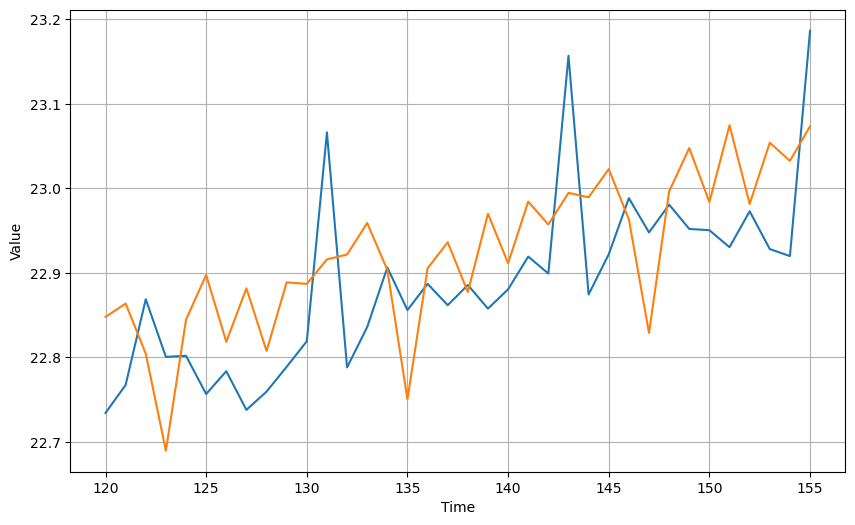

In [32]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

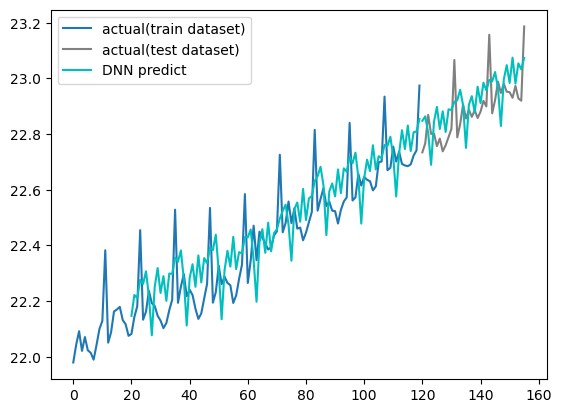

In [33]:
# グラフ化

fig, ax = plt.subplots()
ax.plot(time_train, x_train, label="actual(train dataset)")
ax.plot(time_valid, x_valid, label="actual(test dataset)", color="gray")
ax.plot(time_train_pred, train_pred, color="c")
ax.plot(time_valid, test_pred, label="DNN predict", color="c") 
# ax.fill_between(
#     df_log_test.index,
#     test_pred_ci[:, 0],
#     test_pred_ci[:, 1],
#     color='c',
#     alpha=.2)
ax.legend()

In [34]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.0036618525548527125


In [35]:
# ここまででエポック数500から1000までがちょうどよさそう
# keras tunerでパラメータチューニングする際、エポック数は500・1000で試してみることにする

In [37]:
%%time
# ReLUでもエポック数を確認する
# エポック数：100
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(ReLU())
model.add(Dense(10))
model.add(ReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
4/4 [==============================] - 1s 11ms/step - loss: 44.7296
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 43.8015
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 42.7366
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 41.6580
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 40.5735
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 39.4838
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 38.3888
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 37.2884
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 36.1819
Epoch 10/100
4/4 [==============================] - 0s 3ms/step - loss: 35.0695
Epoch 11/100
4/4 [==============================] - 0s 3ms/step - loss: 33.9516
Epoch 12/100
4/4 [==============================] - 0s 2ms/step - loss: 32.8276
Epoch 13/100
4/4 [==============================

1/1 [==============================] - 0s 26ms/step


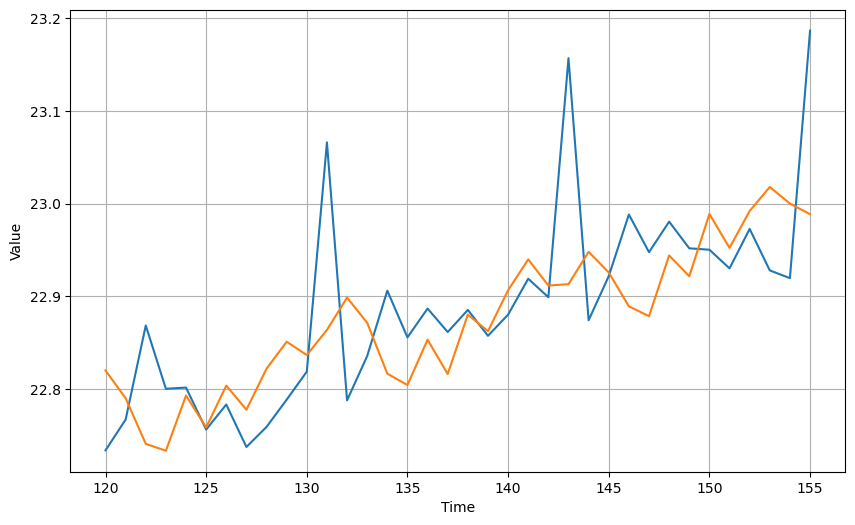

In [38]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [42]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.002614388433676652


In [43]:
%%time
# ReLUでもエポック数を確認する
# エポック数：500
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(ReLU())
model.add(Dense(10))
model.add(ReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 51ms/step - loss: 45.0911
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 43.4777
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 41.6490
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 39.8250
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 38.0184
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 36.2296
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 34.4598
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 32.7066
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 30.9703
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 29.2502
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 27.5473
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 25.8615
Epoch 13/500
4/4 [==============================] - 0s 5ms/s

4/4 [==============================] - 0s 3ms/step - loss: 0.3980
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4000
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4364
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4436
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3942
Epoch 109/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4036
Epoch 110/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4013
Epoch 111/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4071
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4095
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3989
Epoch 114/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4087
Epoch 115/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3975
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.4031
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4316
Epoch 208/500
4/4 [==============================] - 0s 1ms/step - loss: 0.4030
Epoch 209/500
4/4 [==============================] - 0s 12ms/step - loss: 0.3998
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4014
Epoch 211/500
4/4 [==============================] - 0s 1ms/step - loss: 0.4085
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3997
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4017
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4092
Epoch 215/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3997
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4052
Epoch 217/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4071
Epoch 218/500
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 0.3986
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3989
Epoch 310/500
4/4 [==============================] - 0s 1ms/step - loss: 0.3980
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4053
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4051
Epoch 313/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4001
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4042
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4219
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4111
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4007
Epoch 318/500
4/4 [==============================] - 0s 1ms/step - loss: 0.3981
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4034
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.4061
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4085
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3979
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3990
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4081
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4200
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3998
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4252
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4124
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3981
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4059
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3985
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 18ms/step


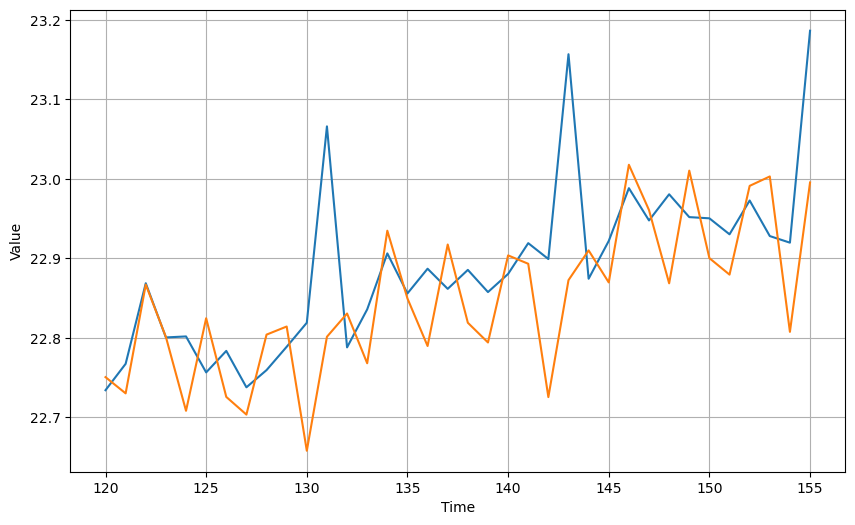

In [44]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [45]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.0030739933078331293


In [46]:
%%time
# ReLUでもエポック数を確認する
# エポック数：1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(ReLU())
model.add(Dense(10))
model.add(ReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 0s 10ms/step - loss: 67.2786
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 66.0458
Epoch 3/1000
4/4 [==============================] - 0s 3ms/step - loss: 64.6342
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 63.2078
Epoch 5/1000
4/4 [==============================] - 0s 3ms/step - loss: 61.7767
Epoch 6/1000
4/4 [==============================] - 0s 3ms/step - loss: 60.3427
Epoch 7/1000
4/4 [==============================] - 0s 3ms/step - loss: 58.9054
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 57.4637
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 56.0174
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 54.5663
Epoch 11/1000
4/4 [==============================] - 0s 4ms/step - loss: 53.1117
Epoch 12/1000
4/4 [==============================] - 0s 8ms/step - loss: 51.6530
Epoch 13/1000
4/4 [==============================

4/4 [==============================] - 0s 3ms/step - loss: 0.4372
Epoch 104/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4982
Epoch 105/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4716
Epoch 106/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4956
Epoch 107/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4492
Epoch 108/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4394
Epoch 109/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4428
Epoch 110/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4507
Epoch 111/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4403
Epoch 112/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4467
Epoch 113/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4413
Epoch 114/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4408
Epoch 115/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.4449
Epoch 205/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4391
Epoch 206/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4368
Epoch 207/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4490
Epoch 208/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4390
Epoch 209/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4467
Epoch 210/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4435
Epoch 211/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4365
Epoch 212/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4483
Epoch 213/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4690
Epoch 214/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4892
Epoch 215/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4496
Epoch 216/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.4432
Epoch 306/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4425
Epoch 307/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4361
Epoch 308/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4393
Epoch 309/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4683
Epoch 310/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4478
Epoch 311/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4495
Epoch 312/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4377
Epoch 313/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4395
Epoch 314/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4434
Epoch 315/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4523
Epoch 316/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4397
Epoch 317/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.4413
Epoch 407/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4424
Epoch 408/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4407
Epoch 409/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4458
Epoch 410/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4476
Epoch 411/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4354
Epoch 412/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4409
Epoch 413/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4429
Epoch 414/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4368
Epoch 415/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4346
Epoch 416/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.4471
Epoch 417/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4403
Epoch 418/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.4363
Epoch 508/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4438
Epoch 509/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4374
Epoch 510/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4349
Epoch 511/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4478
Epoch 512/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4387
Epoch 513/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4399
Epoch 514/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4374
Epoch 515/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4371
Epoch 516/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4377
Epoch 517/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4489
Epoch 518/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4356
Epoch 519/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.4630
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4357
Epoch 610/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4624
Epoch 611/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.4360
Epoch 612/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.4395
Epoch 613/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4371
Epoch 614/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.4347
Epoch 615/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4343
Epoch 616/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4385
Epoch 617/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.4439
Epoch 618/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.4505
Epoch 619/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.4437
Epoch 620/1000
4/4 [=======================

4/4 [==============================] - 0s 5ms/step - loss: 0.4425
Epoch 710/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4340
Epoch 711/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4489
Epoch 712/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4380
Epoch 713/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4351
Epoch 714/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4486
Epoch 715/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4407
Epoch 716/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4357
Epoch 717/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4461
Epoch 718/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4395
Epoch 719/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 720/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4778
Epoch 721/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.4332
Epoch 811/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4390
Epoch 812/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4473
Epoch 813/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4354
Epoch 814/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4427
Epoch 815/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.4392
Epoch 816/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4364
Epoch 817/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4577
Epoch 818/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4342
Epoch 819/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4417
Epoch 820/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4479
Epoch 821/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4407
Epoch 822/1000
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 0.4365
Epoch 912/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4344
Epoch 913/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.4350
Epoch 914/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4673
Epoch 915/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4386
Epoch 916/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.4387
Epoch 917/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4464
Epoch 918/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4524
Epoch 919/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.4531
Epoch 920/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.4449
Epoch 921/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4426
Epoch 922/1000
4/4 [==============================] - 0s 3ms/step - loss: 0.4474
Epoch 923/1000
4/4 [======================

1/1 [==============================] - 0s 28ms/step


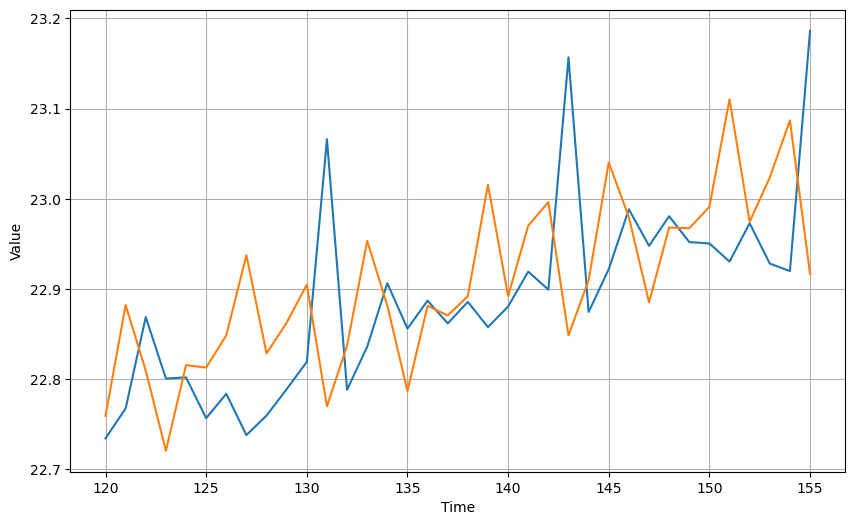

In [47]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [48]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.0036980427783501074


In [50]:
# ここまでReLU・PReLU共にあまり当てはめられていないように見える

In [55]:
# 一旦別の活性化関数も試してみる

In [56]:
%%time
# sigmoid
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="sigmoid"), 
    tf.keras.layers.Dense(10, activation="sigmoid"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 48ms/step - loss: 106.0389
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 106.0377
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 106.0363
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 106.0350
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 106.0336
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 106.0323
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 106.0309
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 106.0295
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 106.0281
Epoch 10/500
4/4 [==============================] - 0s 24ms/step - loss: 106.0267
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 106.0253
Epoch 12/500
4/4 [==============================] - 0s 7ms/step - loss: 106.0239
Epoch 13/500
4/4 [=============================

4/4 [==============================] - 0s 2ms/step - loss: 105.8665
Epoch 103/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8644
Epoch 104/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8623
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8603
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8582
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8561
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8540
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8519
Epoch 110/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8498
Epoch 111/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8477
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 105.8456
Epoch 113/500
4/4 [==============================] - 0s 4ms/step - loss: 105.8435
Epoch 114/500
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 105.6645
Epoch 203/500
4/4 [==============================] - 0s 4ms/step - loss: 105.6628
Epoch 204/500
4/4 [==============================] - 0s 4ms/step - loss: 105.6610
Epoch 205/500
4/4 [==============================] - 0s 7ms/step - loss: 105.6593
Epoch 206/500
4/4 [==============================] - 0s 3ms/step - loss: 105.6576
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 105.6559
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 105.6542
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 105.6525
Epoch 210/500
4/4 [==============================] - 0s 11ms/step - loss: 105.6508
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 105.6491
Epoch 212/500
4/4 [==============================] - 0s 4ms/step - loss: 105.6475
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 105.6458
Epoch 214/500
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 105.5265
Epoch 303/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5254
Epoch 304/500
4/4 [==============================] - 0s 2ms/step - loss: 105.5243
Epoch 305/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5232
Epoch 306/500
4/4 [==============================] - 0s 10ms/step - loss: 105.5222
Epoch 307/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5211
Epoch 308/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5200
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5190
Epoch 310/500
4/4 [==============================] - 0s 11ms/step - loss: 105.5179
Epoch 311/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5168
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5158
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 105.5147
Epoch 314/500
4/4 [=========

4/4 [==============================] - 0s 5ms/step - loss: 105.4328
Epoch 403/500
4/4 [==============================] - 0s 3ms/step - loss: 105.4320
Epoch 404/500
4/4 [==============================] - 0s 3ms/step - loss: 105.4312
Epoch 405/500
4/4 [==============================] - 0s 4ms/step - loss: 105.4304
Epoch 406/500
4/4 [==============================] - 0s 3ms/step - loss: 105.4296
Epoch 407/500
4/4 [==============================] - 0s 3ms/step - loss: 105.4287
Epoch 408/500
4/4 [==============================] - 0s 7ms/step - loss: 105.4279
Epoch 409/500
4/4 [==============================] - 0s 4ms/step - loss: 105.4271
Epoch 410/500
4/4 [==============================] - 0s 4ms/step - loss: 105.4263
Epoch 411/500
4/4 [==============================] - 0s 8ms/step - loss: 105.4255
Epoch 412/500
4/4 [==============================] - 0s 9ms/step - loss: 105.4247
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 105.4239
Epoch 414/500
4/4 [===========

1/1 [==============================] - 0s 16ms/step


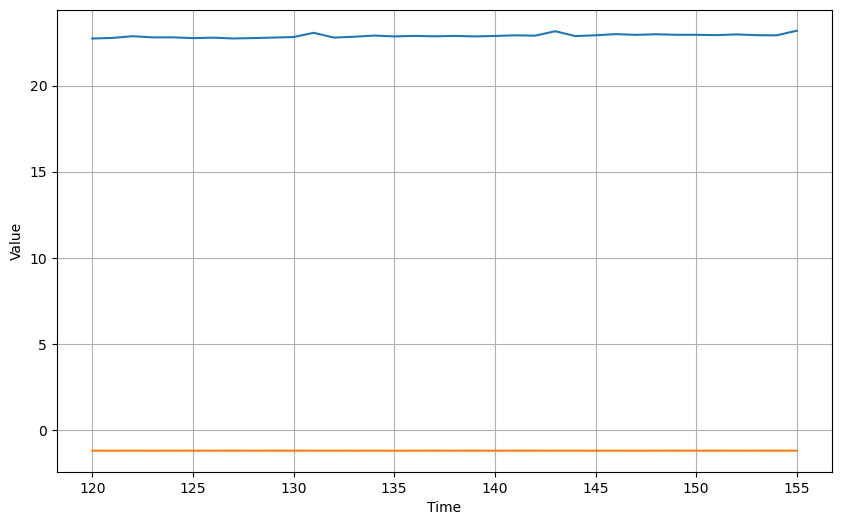

In [57]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [58]:
# 全くダメだった

In [59]:
%%time
# softmax
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="softmax"), 
    tf.keras.layers.Dense(10, activation="softmax"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 0s 11ms/step - loss: 99.9427
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9426
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9424
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9422
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9420
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9419
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9417
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9415
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9413
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9411
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9410
Epoch 12/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9408
Epoch 13/500
4/4 [==============================

4/4 [==============================] - 0s 3ms/step - loss: 99.9243
Epoch 104/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9241
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9240
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9238
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9236
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9234
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9232
Epoch 110/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9231
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9229
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9227
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9225
Epoch 114/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9223
Epoch 115/500
4/4 [=======================

4/4 [==============================] - 0s 1ms/step - loss: 99.9061
Epoch 205/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9059
Epoch 206/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9057
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9055
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9053
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9052
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9050
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9048
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9046
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 99.9044
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9043
Epoch 215/500
4/4 [==============================] - 0s 2ms/step - loss: 99.9041
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 99.8878
Epoch 306/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8876
Epoch 307/500
4/4 [==============================] - 0s 3ms/step - loss: 99.8874
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8873
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8871
Epoch 310/500
4/4 [==============================] - 0s 3ms/step - loss: 99.8869
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8867
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8865
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 99.8864
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 99.8862
Epoch 315/500
4/4 [==============================] - 0s 5ms/step - loss: 99.8860
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8858
Epoch 317/500
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 99.8696
Epoch 407/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8694
Epoch 408/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8692
Epoch 409/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8690
Epoch 410/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8688
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8686
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8685
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 99.8683
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 99.8681
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8679
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8677
Epoch 417/500
4/4 [==============================] - 0s 2ms/step - loss: 99.8676
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 13ms/step


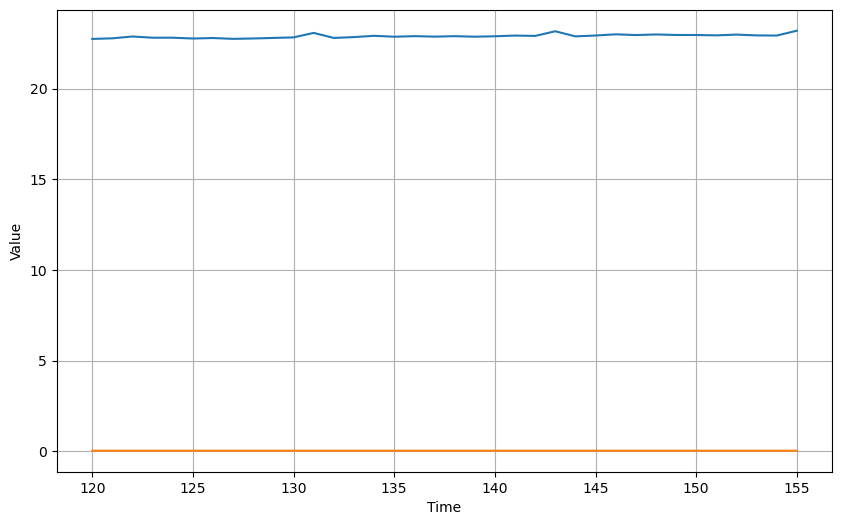

In [60]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [61]:
# softmaxも全く学習できず

In [62]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 39ms/step - loss: 132.4958
Epoch 2/500
4/4 [==============================] - 0s 26ms/step - loss: 131.8528
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 131.1214
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 130.3865
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 129.6556
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 128.9289
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 128.2051
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 127.4837
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 126.7779
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 126.1009
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 125.4592
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 124.9597
Epoch 13/500
4/4 [=================

4/4 [==============================] - 0s 2ms/step - loss: 109.5256
Epoch 103/500
4/4 [==============================] - 0s 2ms/step - loss: 109.4600
Epoch 104/500
4/4 [==============================] - 0s 2ms/step - loss: 109.3945
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 109.3295
Epoch 106/500
4/4 [==============================] - 0s 3ms/step - loss: 109.2647
Epoch 107/500
4/4 [==============================] - 0s 5ms/step - loss: 109.2003
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 109.1364
Epoch 109/500
4/4 [==============================] - 0s 3ms/step - loss: 109.0726
Epoch 110/500
4/4 [==============================] - 0s 3ms/step - loss: 109.0092
Epoch 111/500
4/4 [==============================] - 0s 4ms/step - loss: 108.9461
Epoch 112/500
4/4 [==============================] - 0s 4ms/step - loss: 108.8834
Epoch 113/500
4/4 [==============================] - 0s 3ms/step - loss: 108.8208
Epoch 114/500
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 104.2888
Epoch 203/500
4/4 [==============================] - 0s 4ms/step - loss: 104.2472
Epoch 204/500
4/4 [==============================] - 0s 3ms/step - loss: 104.2062
Epoch 205/500
4/4 [==============================] - 0s 2ms/step - loss: 104.1658
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 104.1257
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 104.0862
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 104.0471
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 104.0082
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 103.9699
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 103.9324
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 103.8948
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 103.8574
Epoch 214/500
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 101.2523
Epoch 303/500
4/4 [==============================] - 0s 2ms/step - loss: 101.2290
Epoch 304/500
4/4 [==============================] - 0s 3ms/step - loss: 101.2061
Epoch 305/500
4/4 [==============================] - 0s 2ms/step - loss: 101.1822
Epoch 306/500
4/4 [==============================] - 0s 3ms/step - loss: 101.1590
Epoch 307/500
4/4 [==============================] - 0s 2ms/step - loss: 101.1364
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 101.1130
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 101.0895
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 101.0669
Epoch 311/500
4/4 [==============================] - 0s 3ms/step - loss: 101.0439
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 101.0208
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 100.9978
Epoch 314/500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 99.5268
Epoch 403/500
4/4 [==============================] - 0s 7ms/step - loss: 99.5245
Epoch 404/500
4/4 [==============================] - 0s 5ms/step - loss: 99.5220
Epoch 405/500
4/4 [==============================] - 0s 4ms/step - loss: 99.5200
Epoch 406/500
4/4 [==============================] - 0s 2ms/step - loss: 99.5179
Epoch 407/500
4/4 [==============================] - 0s 3ms/step - loss: 99.5162
Epoch 408/500
4/4 [==============================] - 0s 3ms/step - loss: 99.5138
Epoch 409/500
4/4 [==============================] - 0s 2ms/step - loss: 99.5116
Epoch 410/500
4/4 [==============================] - 0s 2ms/step - loss: 99.5101
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 99.5080
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 99.5063
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 99.5047
Epoch 414/500
4/4 [=======================

In [63]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 0s 7ms/step - loss: 26.2922
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 25.6829
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 24.9820
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 24.2700
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 23.5522
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 22.8282
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 22.0981
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 21.3620
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 20.6197
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 19.8714
Epoch 11/500
4/4 [==============================] - 0s 2ms/step - loss: 19.1170
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 18.3562
Epoch 13/500
4/4 [==============================]

4/4 [==============================] - 0s 3ms/step - loss: 0.3888
Epoch 105/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3894
Epoch 106/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3855
Epoch 107/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3797
Epoch 108/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3796
Epoch 109/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3791
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3818
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3779
Epoch 112/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3821
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3814
Epoch 114/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3836
Epoch 115/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3808
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3796
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3785
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3769
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 211/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3766
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3779
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3860
Epoch 214/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3850
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3829
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3818
Epoch 217/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3757
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.3772
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4009
Epoch 310/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3754
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3778
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3849
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3760
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3862
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3780
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3814
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3897
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3843
Epoch 319/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3764
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.3798
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3753
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3776
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3774
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3760
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3756
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3786
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3831
Epoch 418/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3754
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3796
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3841
Epoch 421/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3807
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 18ms/step


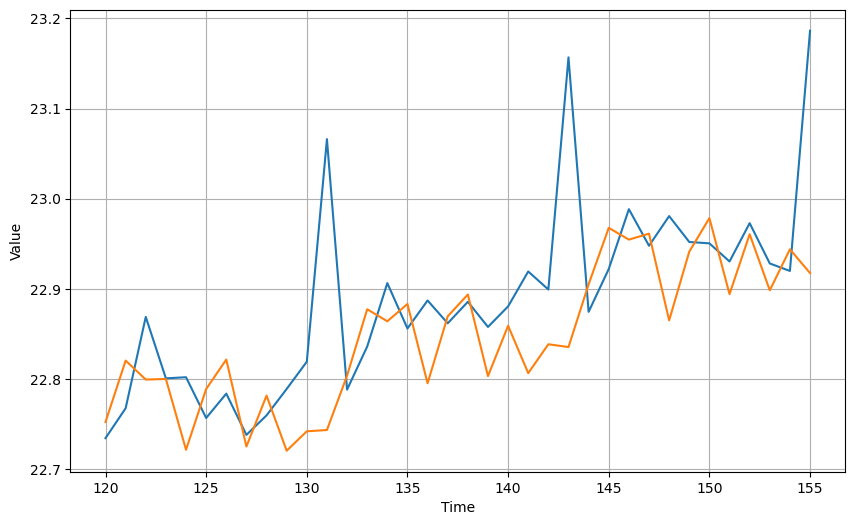

In [64]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [65]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.0027201157427174994


In [66]:
# 活性化関数はPReLU・ReLUの比較のみでよさそう
# エポック数は500・1000の二つで比較

In [72]:
%%time
# 学習率の大まかなエリアを絞り込む
# PReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 15.9 s, sys: 1.99 s, total: 17.9 s
Wall time: 16.4 s


(1e-08, 0.001, 0.0, 300.0)

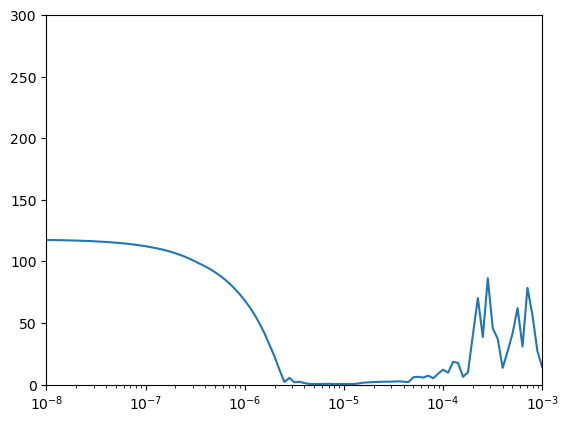

In [73]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 20.0)

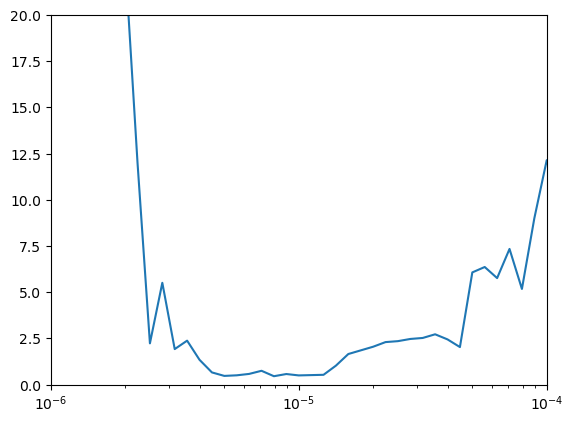

In [74]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

In [75]:
%%time
# 学習率の大まかなエリアを絞り込む
# PReLU・エポック数1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=1000, callbacks=[lr_schedule], verbose=0)

CPU times: user 27.6 s, sys: 4.04 s, total: 31.7 s
Wall time: 22.2 s


(1e-08, 0.001, 0.0, 300.0)

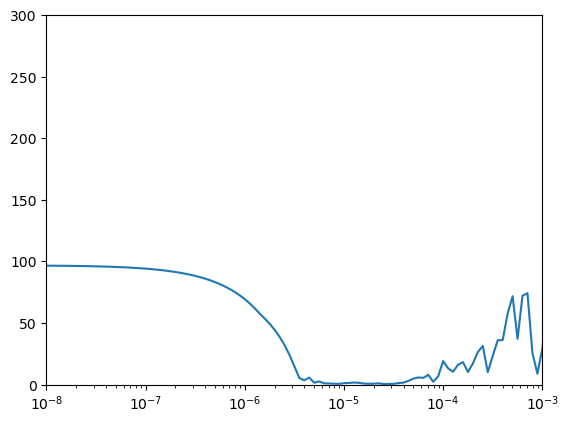

In [77]:
lrs = 1e-8 * (10 ** (np.arange(1000) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 20.0)

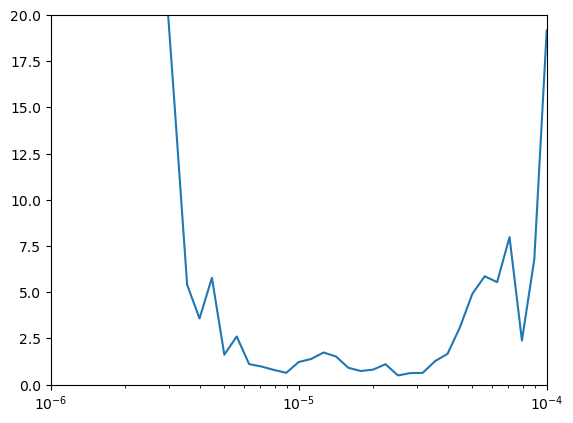

In [79]:
lrs = 1e-8 * (10 ** (np.arange(1000) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

In [80]:
# PReLUは0.5〜5*10^-5くらいのエポック数でMAPEが最小になる

In [81]:
%%time
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(ReLU())
model.add(Dense(10))
model.add(ReLU())
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 16.5 s, sys: 2.04 s, total: 18.6 s
Wall time: 21 s


(1e-06, 0.0001, 0.0, 20.0)

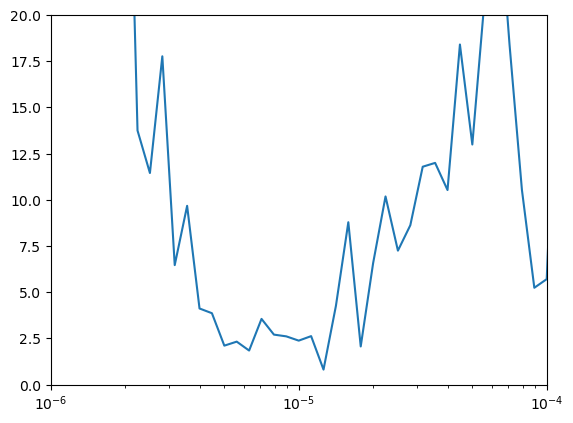

In [82]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

(1e-06, 0.0001, 0.0, 20.0)

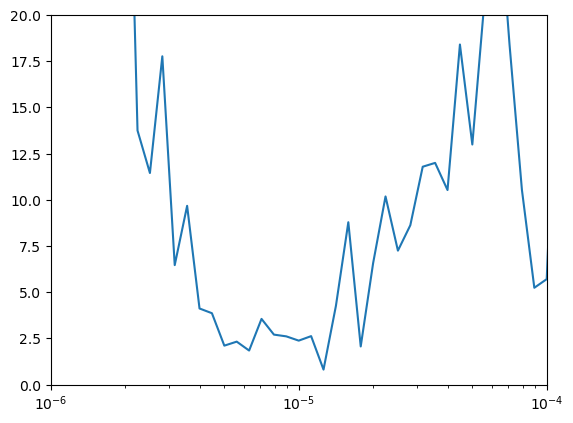

In [83]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

In [84]:
%%time
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(ReLU())
model.add(Dense(10))
model.add(ReLU())
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=1000, callbacks=[lr_schedule], verbose=0)

CPU times: user 32.2 s, sys: 3.87 s, total: 36.1 s
Wall time: 39.1 s


(1e-06, 0.0001, 0.0, 20.0)

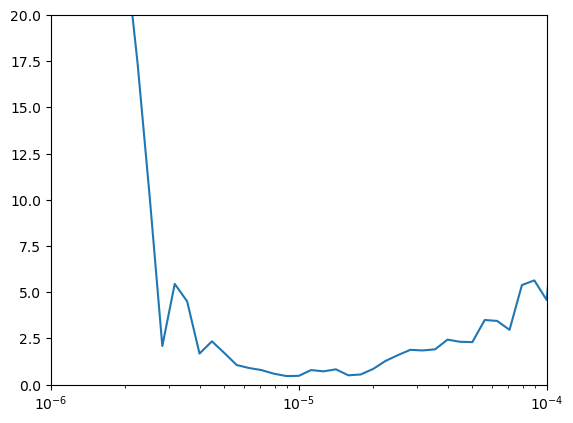

In [85]:
lrs = 1e-8 * (10 ** (np.arange(1000) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

(1e-06, 0.0001, 0.0, 20.0)

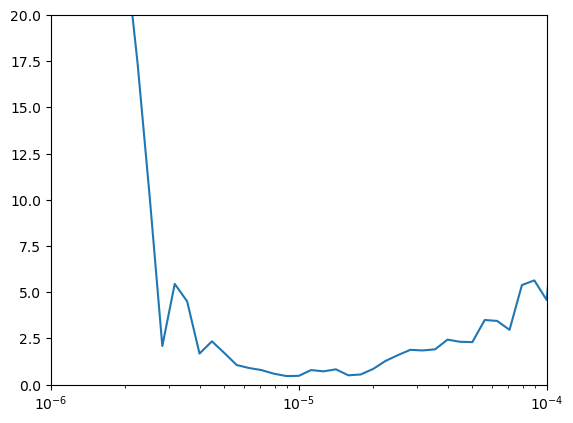

In [86]:
lrs = 1e-8 * (10 ** (np.arange(1000) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

In [87]:
# ReLUも0.5〜5*10^-5くらいのエポック数でMAPEが最小になる

In [98]:
%%time
# keras tunerを使って、パラメータを調整する
# PReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=10, max_value=30, step=2), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units2', min_value=10, max_value=30, step=2)))
  model.add(PReLU())
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9, 1.0, 3.0, 5.0]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='PReLU_500')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=0)

Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
momentum (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.7, 0.9, 1.0, 3.0, 5.0], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 40min 38s, sys: 5min 10s, total: 45min 49s
Wall time: 39min 44s


In [99]:
tuner.results_summary()

Results summary
Results in my_dir/PReLU_500
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 12
units2: 18
momentum: 0.7
Score: 0.3150167167186737
Trial summary
Hyperparameters:
units1: 18
units2: 20
momentum: 0.7
Score: 0.3270075519879659
Trial summary
Hyperparameters:
units1: 26
units2: 28
momentum: 1.0
Score: 0.33267731467882794
Trial summary
Hyperparameters:
units1: 14
units2: 10
momentum: 3.0
Score: 0.33416956663131714
Trial summary
Hyperparameters:
units1: 24
units2: 16
momentum: 1.0
Score: 0.33922462662061054
Trial summary
Hyperparameters:
units1: 22
units2: 30
momentum: 0.9
Score: 0.34978286425272626
Trial summary
Hyperparameters:
units1: 20
units2: 28
momentum: 1.0
Score: 0.3577379584312439
Trial summary
Hyperparameters:
units1: 22
units2: 14
momentum: 3.0
Score: 0.35846054553985596
Trial summary
Hyperparameters:
units1: 10
units2: 20
momentum: 0.5
Score: 0.382438987493515
Trial summary
Hyperparameters:
units1: 16
units2: 26
momentum: 3.0
Score: 0.3882902165253957

In [106]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(12, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(18))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.7))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 22ms/step - loss: 118.9336
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 105.5417
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 89.5758
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 76.9435
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 67.5022
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 58.6061
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 49.0231
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 38.5685
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 27.0259
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 14.1695
Epoch 11/500
4/4 [==============================] - 0s 2ms/step - loss: 2.3967
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 1.8486
Epoch 13/500
4/4 [==============================

4/4 [==============================] - 0s 2ms/step - loss: 0.3215
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4907
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5177
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7809
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3337
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3371
Epoch 110/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3240
Epoch 111/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7341
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6951
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3949
Epoch 114/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3647
Epoch 115/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5146
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.4190
Epoch 207/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3543
Epoch 208/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5530
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3101
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3710
Epoch 211/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6165
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7990
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5979
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4758
Epoch 215/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4982
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3315
Epoch 217/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8126
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.4975
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4575
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4625
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7644
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4375
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4083
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4250
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7990
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5856
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5174
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4029
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.4000
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4093
Epoch 412/500
4/4 [==============================] - 0s 7ms/step - loss: 0.6508
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 0.7737
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3091
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3595
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4612
Epoch 417/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3710
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3226
Epoch 419/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3088
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4237
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3358
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 37ms/step


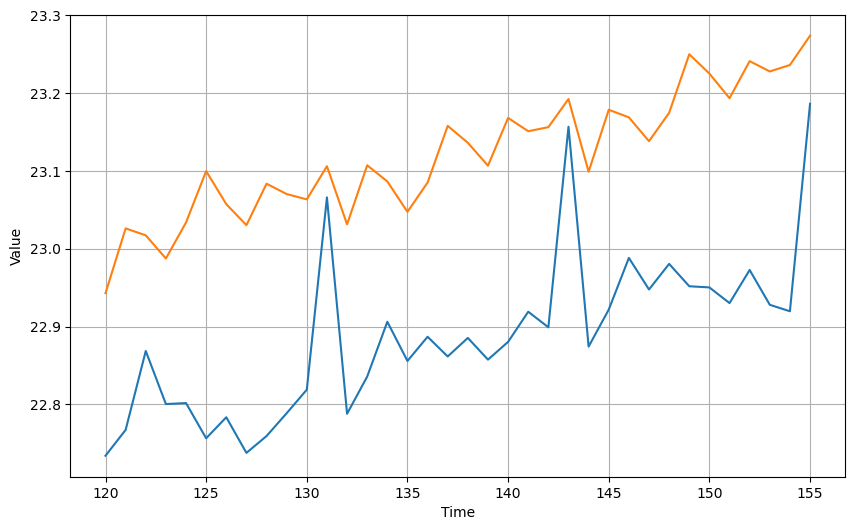

In [107]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [108]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.01018437612671135


In [109]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(18, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(20))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.7))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 18ms/step - loss: 58.5950
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 28.1293
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 3.5488
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 5.7290
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 2.6798
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 3.3296
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 4.3088
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 2.2764
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 2.1916
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 0.5961
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 1.4449
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 1.0779
Epoch 13/500
4/4 [==============================] - 0s 3ms/step - loss

4/4 [==============================] - 0s 2ms/step - loss: 1.1040
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8223
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7480
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 2.2372
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0300
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 0.9207
Epoch 110/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0887
Epoch 111/500
4/4 [==============================] - 0s 2ms/step - loss: 2.0015
Epoch 112/500
4/4 [==============================] - 0s 3ms/step - loss: 1.8929
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 1.9598
Epoch 114/500
4/4 [==============================] - 0s 2ms/step - loss: 1.8161
Epoch 115/500
4/4 [==============================] - 0s 3ms/step - loss: 2.0362
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 5ms/step - loss: 1.6942
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 1.7051
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5619
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 1.6850
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 1.7294
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 1.7629
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 1.7592
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 1.8200
Epoch 214/500
4/4 [==============================] - 0s 6ms/step - loss: 1.7871
Epoch 215/500
4/4 [==============================] - 0s 2ms/step - loss: 1.8547
Epoch 216/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5816
Epoch 217/500
4/4 [==============================] - 0s 2ms/step - loss: 1.5388
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 1.6075
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 1.6417
Epoch 310/500
4/4 [==============================] - 0s 3ms/step - loss: 1.6218
Epoch 311/500
4/4 [==============================] - 0s 3ms/step - loss: 1.7781
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 1.4656
Epoch 313/500
4/4 [==============================] - 0s 5ms/step - loss: 1.6033
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5376
Epoch 315/500
4/4 [==============================] - 0s 4ms/step - loss: 1.6210
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 1.5671
Epoch 317/500
4/4 [==============================] - 0s 4ms/step - loss: 1.7590
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 1.6698
Epoch 319/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5495
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 1.4203
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 1.5357
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 1.5932
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5026
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4706
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5093
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 1.5069
Epoch 417/500
4/4 [==============================] - 0s 2ms/step - loss: 1.5693
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 1.4780
Epoch 419/500
4/4 [==============================] - 0s 8ms/step - loss: 1.4000
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4934
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 1.5564
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 24ms/step


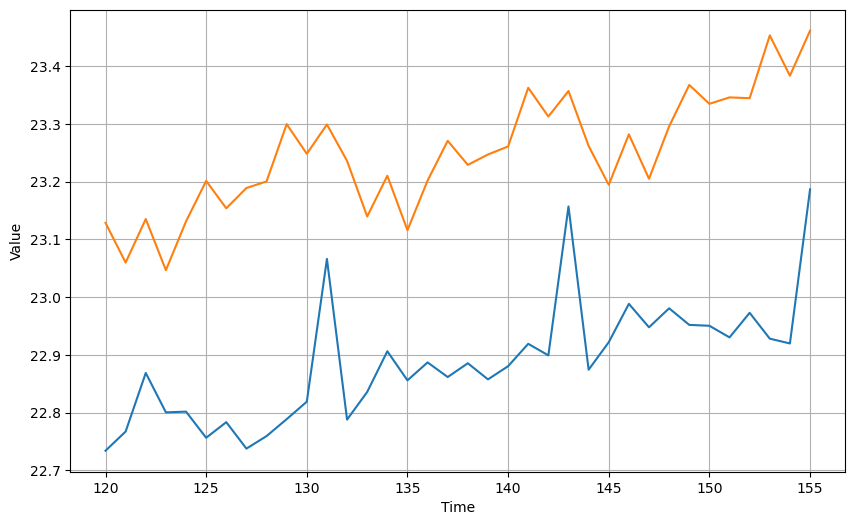

In [110]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [111]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.015770187875431406


In [112]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 2s 194ms/step - loss: 104.0309
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 103.6577
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 103.2315
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 102.8024
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 102.3737
Epoch 6/500
4/4 [==============================] - 0s 87ms/step - loss: 101.9454
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 101.5176
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 101.0903
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 100.6634
Epoch 10/500
4/4 [==============================] - 0s 8ms/step - loss: 100.2368
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 99.8107
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 99.3849
Epoch 13/500
4/4 [==================

4/4 [==============================] - 0s 4ms/step - loss: 45.1227
Epoch 104/500
4/4 [==============================] - 0s 2ms/step - loss: 44.3006
Epoch 105/500
4/4 [==============================] - 0s 3ms/step - loss: 43.4735
Epoch 106/500
4/4 [==============================] - 0s 4ms/step - loss: 42.6414
Epoch 107/500
4/4 [==============================] - 0s 3ms/step - loss: 41.8035
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 40.9602
Epoch 109/500
4/4 [==============================] - 0s 3ms/step - loss: 40.1116
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 39.2568
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 38.3964
Epoch 112/500
4/4 [==============================] - 0s 3ms/step - loss: 37.5301
Epoch 113/500
4/4 [==============================] - 0s 3ms/step - loss: 36.6581
Epoch 114/500
4/4 [==============================] - 0s 3ms/step - loss: 35.7804
Epoch 115/500
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 0.3557
Epoch 206/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3680
Epoch 207/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3807
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3601
Epoch 209/500
4/4 [==============================] - 0s 13ms/step - loss: 0.3609
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3547
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3597
Epoch 212/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3548
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3621
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3537
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3607
Epoch 216/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3545
Epoch 217/500
4/4 [==============================] - 

4/4 [==============================] - 0s 5ms/step - loss: 0.3552
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3650
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3561
Epoch 310/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3598
Epoch 311/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3554
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3603
Epoch 313/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3537
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3544
Epoch 315/500
4/4 [==============================] - 0s 7ms/step - loss: 0.3557
Epoch 316/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3847
Epoch 317/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3599
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3531
Epoch 319/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.3542
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3580
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3576
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3650
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3549
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3545
Epoch 415/500
4/4 [==============================] - 0s 6ms/step - loss: 0.3533
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3568
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3583
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3585
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3725
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3528
Epoch 421/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 36ms/step


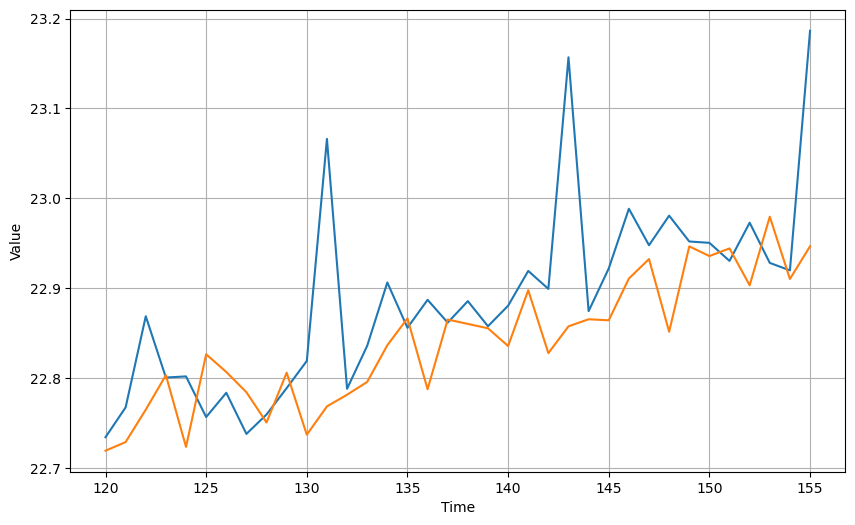

In [113]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [114]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.002626027820683238


In [116]:
%%time
# keras tunerを使って、パラメータを調整する
# PReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=10, step=2), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=10, step=2)))
  model.add(PReLU())
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9, 1.0, 3.0, 5.0]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='PReLU')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=0)

Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': None}
momentum (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.7, 0.9, 1.0, 3.0, 5.0], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 41min 7s, sys: 5min 8s, total: 46min 15s
Wall time: 44min 55s


In [117]:
# 気づいたけど、MAPEの比較は指数変換して元系列に戻してから出ないとダメでは？

In [118]:
tuner.results_summary()

Results summary
Results in my_dir/PReLU
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 4
units2: 4
momentum: 0.7
Score: 0.28377483288447064
Trial summary
Hyperparameters:
units1: 10
units2: 10
momentum: 1.0
Score: 0.3176664412021637
Trial summary
Hyperparameters:
units1: 8
units2: 10
momentum: 0.5
Score: 0.31846705079078674
Trial summary
Hyperparameters:
units1: 8
units2: 2
momentum: 0.7
Score: 0.3195137083530426
Trial summary
Hyperparameters:
units1: 6
units2: 8
momentum: 0.7
Score: 0.3275982936223348
Trial summary
Hyperparameters:
units1: 10
units2: 2
momentum: 5.0
Score: 0.3282330830891927
Trial summary
Hyperparameters:
units1: 6
units2: 4
momentum: 1.0
Score: 0.3284442722797394
Trial summary
Hyperparameters:
units1: 10
units2: 4
momentum: 0.5
Score: 0.3363466461499532
Trial summary
Hyperparameters:
units1: 6
units2: 6
momentum: 5.0
Score: 0.3383033573627472
Trial summary
Hyperparameters:
units1: 4
units2: 10
momentum: 0.7
Score: 0.3441736002763112


In [119]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(4, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(4))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.7))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 34ms/step - loss: 269.8881
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 240.2564
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 204.6076
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 171.7960
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 142.8105
Epoch 6/500
4/4 [==============================] - 0s 21ms/step - loss: 116.9406
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 93.2344
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 70.7679
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 48.7013
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 26.2439
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1290
Epoch 12/500
4/4 [==============================] - 0s 2ms/step - loss: 2.8114
Epoch 13/500
4/4 [=========================

4/4 [==============================] - 0s 2ms/step - loss: 0.9062
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8922
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 1.1996
Epoch 107/500
4/4 [==============================] - 0s 3ms/step - loss: 1.0019
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3845
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6274
Epoch 110/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5399
Epoch 111/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0574
Epoch 112/500
4/4 [==============================] - 0s 3ms/step - loss: 1.0610
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8919
Epoch 114/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6695
Epoch 115/500
4/4 [==============================] - 0s 2ms/step - loss: 1.1550
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.8542
Epoch 207/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7429
Epoch 208/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4055
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0170
Epoch 211/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5429
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8574
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4939
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4065
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2876
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0599
Epoch 217/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3996
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 0.5394
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7452
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6329
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4663
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3722
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 0.6406
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.6801
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3825
Epoch 316/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4404
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3949
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4028
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5948
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 0.4673
Epoch 411/500
4/4 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8225
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 0.5258
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 0.3966
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 0.5301
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 0.8736
Epoch 417/500
4/4 [==============================] - 0s 2ms/step - loss: 0.9853
Epoch 418/500
4/4 [==============================] - 0s 2ms/step - loss: 0.4542
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4066
Epoch 420/500
4/4 [==============================] - 0s 3ms/step - loss: 0.9011
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 0.8390
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 18ms/step


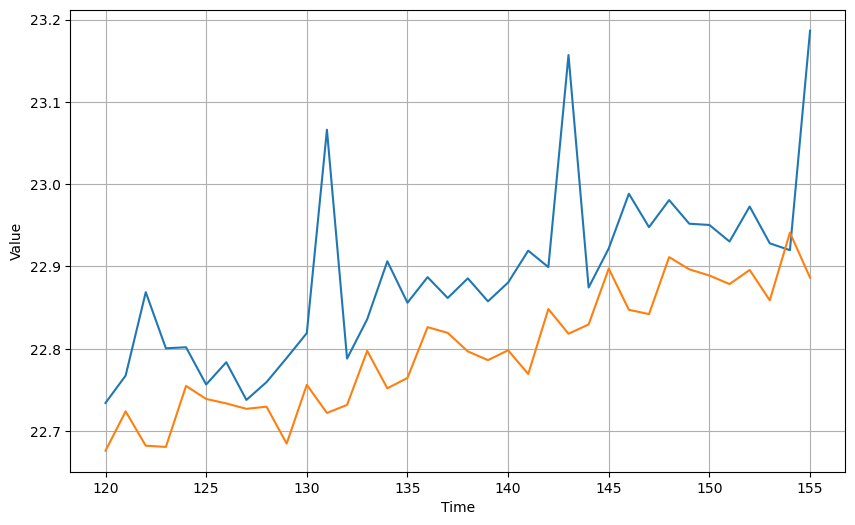

In [120]:
forecast = []
for time in range(156 - window_size):     # 2022年12月のデータが取得できれば168に変更
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [121]:
print('MAPE：')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE：
0.004019435197040614
